In [20]:
! pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib
! pip install -U ipywidgets
! pip install numpy==1.26.4
! pip install urllib3==1.26.6

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=8595) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


In [13]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, Union, Callable
import pickle
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from flwr.server.strategy import Strategy
import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context, Status, GetParametersRes, Parameters, GetParametersIns, MetricsAggregationFn,NDArrays,Scalar
from flwr.server import ServerApp, ServerConfig, ServerAppComponents 
from flwr.server.strategy import FedAvg, FedProx
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    ParametersRecord,
    array_from_numpy
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "mps"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on mps
Flower 1.15.1 / PyTorch 2.6.0


In [2]:

BATCH_SIZE = 32
from flwr_datasets.partitioner import DirichletPartitioner
def load_datasets(partition_id, num_partitions: int):
    drichlet_partitioner = DirichletPartitioner(num_partitions=num_partitions, alpha=0.1, partition_by="label")
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": drichlet_partitioner})
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    valloader = DataLoader(partition_train_test["test"], batch_size=32)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=32)
    return trainloader, valloader, testloader

In [14]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 180)
        self.fc2 = nn.Linear(180, 160)
        self.fc3 = nn.Linear(160, 140)
        self.fc4 = nn.Linear(140, 120)
        self.fc5 = nn.Linear(120, 84)
        self.fc7 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc7(x)
        return x
    


class MoonNet(nn.Module):
    """Returns both the representation (penultimate layer output) and classification"""
    def __init__(self) -> None:
        super(MoonNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 180)
        self.fc2 = nn.Linear(180, 160)
        self.fc3 = nn.Linear(160, 140)
        self.fc4 = nn.Linear(140, 120)
        self.fc5 = nn.Linear(120, 84)
        self.fc7 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        representation = x.clone()
        classification = self.fc7(x)
        return representation, classification

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters, trainable_layers=-1):
    """Set model parameters from a list of NumPy arrays."""
    current_state = OrderedDict(net.state_dict())
    
    if trainable_layers == -1:
        # Update all parameters
        params_dict = zip(current_state.keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        net.load_state_dict(state_dict, strict=True)
    else:
        # Only update the specified layer's parameters
        # Convert current state to numpy arrays
        numpy_state = [param.cpu().numpy() for param in current_state.values()]
        
        # Update the specific indices with new parameters
        numpy_state[trainable_layers*2] = parameters[0]
        numpy_state[trainable_layers*2 + 1] = parameters[1]
        
        # Convert back to torch and update state dict
        for idx, key in enumerate(current_state.keys()):
            current_state[key] = torch.from_numpy(numpy_state[idx])
        
        net.load_state_dict(current_state, strict=True)


# def set_parameters(net, parameters: List[np.ndarray]):
#     params_dict = zip(net.state_dict().keys(), parameters)
#     state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
#     net.load_state_dict(state_dict, strict=True)

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")
        
def proxima_train(net, trainloader, epochs: int, proximal_mu:float, global_params:List[torch.Tensor]):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)

            proximal_term = 0.0
            for local_weights, global_weights in zip(net.parameters(), global_params):
                proximal_term += (local_weights - global_weights).norm(2)
            loss = criterion(net(images), labels) + (proximal_mu / 2) * proximal_term


            loss.backward()
            optimizer.step()
            
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def train_moon(net,train_loader, global_net,previous_net, epochs, mu, temperature):
    """Training function for MOON."""
    print(f"Started training moon")
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())

    previous_net.eval()
    global_net.eval()
    net.to(DEVICE)
    previous_net.to(DEVICE)
    global_net.to(DEVICE)
    cnt = 0
    cos = torch.nn.CosineSimilarity(dim=-1)

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch in train_loader:
            x, target = batch["img"], batch["label"]
            x, target = x.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            # pro1 is the representation by the current model (Line 14 of Algorithm 1)
            pro1, out = net(x)
            # pro2 is the representation by the global model (Line 15 of Algorithm 1)
            # pro3 is the representation by the previous model (Line 16 of Algorithm 1)
            with torch.no_grad():
                pro2, _ = global_net(x)
                pro3, _ = previous_net(x)

            # posi is the positive pair
            posi = cos(pro1, pro2)
            logits = posi.reshape(-1, 1)

            # nega is the negative pair
            nega = cos(pro1, pro3)
            logits = torch.cat((logits, nega.reshape(-1, 1)), dim=1)

            previous_net.to(DEVICE)
            logits /= temperature
            labels = torch.zeros(x.size(0)).to(DEVICE).long()

            # compute the model-contrastive loss (Line 17 of Algorithm 1)
            loss2 = mu * criterion(logits, labels)

            # compute the cross-entropy loss (Line 13 of Algorithm 1)
            loss1 = criterion(out, target)

            # compute the loss (Line 18 of Algorithm 1)
            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        print(
            "Epoch: %d Loss: %f Loss1: %f Loss2: %f"
            % (epoch, epoch_loss, epoch_loss1, epoch_loss2)
        )


def test_moon(net, testloader):
    """
    Evaluate the network on the entire test set.
    Same as the regular test, but using the MoonNet 
    (where the output is a tuple of (representation, classification) )
    """
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            _, outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy




def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
#         """Freeze specified layers of the model."""
#         for idx, (name, param) in enumerate(model.named_parameters()):
#             if idx == trainable_layers or trainable_layers == -1:
#                 param.requires_grad = True
#             else:
#                 param.requires_grad = False



def freeze_layers(model: torch.nn.Module, trainable_layers: int) -> None:
        """Freeze specified layers of the model."""
        trainable_layers_set = []
        if trainable_layers == -1:
            trainable_layers_set = [-1]
        else:
            trainable_layers_set = [trainable_layers *2, trainable_layers *2 +1]

        for idx, (name, param) in enumerate(model.named_parameters()):
            
            if idx in trainable_layers_set or trainable_layers_set[0] == -1:
                param.requires_grad = True
                print(f"layer index is {idx} and name{name} is trainabe")
            else:
                param.requires_grad = False
                print(f"layer index is {idx} and name{name} is frozen")




In [15]:

NETWORK_LEN = len(Net().state_dict().keys()) //2 
EPOCHS = 8
NUM_PARTITIONS = 6
NUM_OF_CYCLES  = 1
NUM_OF_FULL_UPDATES_BETWEEN_CYCLES = 2
NUM_OF_ROUNDS = (NUM_OF_CYCLES * NUM_OF_FULL_UPDATES_BETWEEN_CYCLES) + (NUM_OF_CYCLES * NETWORK_LEN *2)
print(f"Number of rounds: {NUM_OF_ROUNDS}")
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}


Number of rounds: 18


In [16]:
from flwr.common import NDArrays, Scalar
import sys

# More robust evaluate function:
def get_evaluate_fn(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""
    
    # used to check if they're changing
    previous_params = None
    
    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        nonlocal previous_params
        
        print(f"\n==== Server-side evaluation for round {server_round} ====")
        
        # Check if parameters changed from previous round
        if previous_params is not None:
            param_change = False
            for i, (prev, curr) in enumerate(zip(previous_params, parameters)):
                diff = np.abs(prev - curr).mean()
                if diff > 1e-6:
                    param_change = True
                    print(f"  Parameter {i}: Changed by {diff:.6f}")
            
            if not param_change:
                print("  WARNING: Parameters haven't changed from previous round!")
        
        previous_params = [p.copy() for p in parameters]
        net_copy = copy.deepcopy(net)

        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v, device=DEVICE) for k, v in params_dict})
        
        # Check if state dict keys match model keys
        model_keys = set(net_copy.state_dict().keys())
        params_keys = set(state_dict.keys())
        if model_keys != params_keys:
            print(f"  WARNING: Key mismatch between model and parameters!")
            print(f"  Missing in params: {model_keys - params_keys}")
            print(f"  Extra in params: {params_keys - model_keys}")
        
        net_copy.load_state_dict(state_dict, strict=True)
        net_copy.to(DEVICE)
        net_copy.eval()
        
        # Test the model
        loss, accuracy = test(net_copy, testloader)
        print(f"  Evaluation results - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}
    
    return evaluate


def get_evaluate_fn_moon(
    testloader: DataLoader,
    net: torch.nn.Module,
) -> Callable[[int, NDArrays, Dict[str, Scalar]], Optional[Tuple[float, Dict[str, Scalar]]]]:
    """Return an evaluation function for server-side evaluation."""
    
    # used to check if they're changing
    previous_params = None
    
    def evaluate(
        server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Use the entire test set for evaluation."""
        nonlocal previous_params
        
        print(f"\n==== Server-side evaluation for round {server_round} ====")
        
        # Check if parameters changed from previous round
        if previous_params is not None:
            param_change = False
            for i, (prev, curr) in enumerate(zip(previous_params, parameters)):
                diff = np.abs(prev - curr).mean()
                if diff > 1e-6:
                    param_change = True
                    print(f"  Parameter {i}: Changed by {diff:.6f}")
            
            if not param_change:
                print("  WARNING: Parameters haven't changed from previous round!")
        
        previous_params = [p.copy() for p in parameters]
        net_copy = copy.deepcopy(net)

        # Update model with the latest parameters
        params_dict = zip(net_copy.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v, device=DEVICE) for k, v in params_dict})
        
        # Check if state dict keys match model keys
        model_keys = set(net_copy.state_dict().keys())
        params_keys = set(state_dict.keys())
        if model_keys != params_keys:
            print(f"  WARNING: Key mismatch between model and parameters!")
            print(f"  Missing in params: {model_keys - params_keys}")
            print(f"  Extra in params: {params_keys - model_keys}")
            print(f"  Current params: {model_keys}")
        
        net_copy.load_state_dict(state_dict, strict=True)
        net_copy.to(DEVICE)
        net_copy.eval()
        
        # Test the model
        loss, accuracy = test_moon(net_copy, testloader)
        print(f"  Evaluation results - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Return loss and metrics
        return loss, {"accuracy": accuracy}
    
    return evaluate


def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size


# Normal FedAvg

In [7]:
from typing import Union


from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


fed_avg_result = {}
fed_avg_model_results = {}

class ModifiedFedAvg(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace


    def __repr__(self) -> str:
        return "FedPartAvg"
    

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
    
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)
    


    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_avg_model_results:
            expand_fed_avg_result= {**fed_avg_model_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_avg_result= {"global_loss": loss, "global_metrics": metrics}

        fed_avg_model_results[server_round] = expand_fed_avg_result

        return loss, metrics

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        
        return fit_configurations
    

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) *2
        

        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_size": total_size}
        else:
            expand_fed_avg_result= {"total_size": total_size}

        fed_avg_result[server_round] = expand_fed_avg_result


        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_avg_result:
            expand_fed_avg_result= {**fed_avg_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_avg_result= {"total_loss": total_loss}

        fed_avg_result[server_round] = expand_fed_avg_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [8]:
class NormalFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=EPOCHS)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}



def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return NormalFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [28]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedAvg(
            evaluate_fn=evaluate_fn
        ),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=18, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters



==== Server-side evaluation for round 0 ====


INFO :      initial parameters (loss, other metrics): 0.07212121534347535, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000


(ClientAppActor pid=50771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50771)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=50771) [Client 1] fit, config: {}
(ClientAppActor pid=50768) Epoch 1: train loss 0.05412521958351135, accuracy 0.35491021946353357
(ClientAppActor pid=50769) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50771) Epoch 2: train loss 0.01713082194328308, accuracy 0.8141891891891891 [repeated 8x across cluster]
(ClientAppActor pid=50766) Epoch 4: train loss 0.010725699365139008, accuracy 0.8735632183908046 [repeated 8x across cluster]
(ClientAppActor pid=50768) Epoch 7: train loss 0.030448492616415024, accuracy 0.6544003546885391 [repeated 10x across cluster]
(ClientAppActor pid=50770) Epoch 5: train loss 0.030135873705148697, accuracy 0.6016887816646562 [repeated 9x across cluster]
(ClientAppActor pid=50769) Epoch 7: train loss 0.009884011000394821, accuracy 0.884294009347118 [repeated 5x across cluster]
(ClientAppActor pid=50770) Epoch 8: train loss 0.025188373401761055, accuracy 0.6797346200241254 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 1 ====
  Parameter 0: Changed by 0.022586
  Parameter 1: Changed by 0.028774
  Parameter 2: Changed by 0.019660
  Parameter 3: Changed by 0.031463
  Parameter 4: Changed by 0.015210
  Parameter 5: Changed by 0.025304
  Parameter 6: Changed by 0.011693
  Parameter 7: Changed by 0.037634
  Parameter 8: Changed by 0.010534
  Parameter 9: Changed by 0.036390
  Parameter 10: Changed by 0.007516
  Parameter 11: Changed by 0.030214
  Parameter 12: Changed by 0.006904
  Parameter 13: Changed by 0.022922
  Parameter 14: Changed by 0.042775
  Parameter 15: Changed by 0.040059


INFO :      fit progress: (1, 0.07223118932247162, {'accuracy': 0.1}, 51.35299704200588)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0722, Accuracy: 0.1000


(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=50769)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=50769) [Client 2] evaluate, config: {}
(ClientAppActor pid=50767) Epoch 8: train loss 0.011241104453802109, accuracy 0.8819772942289499


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50766) [Client 4] fit, config: {}
(ClientAppActor pid=50767) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=50770) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=50770)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=50769) Epoch 1: train loss 0.04422774165868759, accuracy 0.4757260031035247
(ClientAppActor pid=50770) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) Epoch 2: train loss 0.011276484467089176, accuracy 0.8635057471264368 [repeated 6x across cluster]
(ClientAppActor pid=50769) Epoch 4: train loss 0.02907901629805565, accuracy 0.6825537574817113 [repeated 7x across cluster]
(ClientAppActor pid=50768) Epoch 5: train loss 0.008042549714446068, accuracy 0.9082512315270936 [repeated 7x across cluster]
(ClientAppActor pid=50770) Epoch 5: train loss 0.010661279782652855, accuracy 0.8871915393654524 [repeated 8x across cluster]
(ClientAppActor pid=50770) Epoch 7: train loss 0.008950652554631233, accuracy 0.9034958871915394 [repeated 10x across cluster]
(ClientAppActor pid=50766) Epoch 8: train loss 0.0076669976115226746, accuracy 0.9197019867549668 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 2 ====
  Parameter 0: Changed by 0.017971
  Parameter 1: Changed by 0.025073
  Parameter 2: Changed by 0.018002
  Parameter 3: Changed by 0.022980
  Parameter 4: Changed by 0.013977
  Parameter 5: Changed by 0.015030
  Parameter 6: Changed by 0.014501
  Parameter 7: Changed by 0.019993
  Parameter 8: Changed by 0.012947
  Parameter 9: Changed by 0.019177
  Parameter 10: Changed by 0.008933
  Parameter 11: Changed by 0.015927
  Parameter 12: Changed by 0.007146
  Parameter 13: Changed by 0.010714
  Parameter 14: Changed by 0.045653
  Parameter 15: Changed by 0.021769


INFO :      fit progress: (2, 0.06929404526948929, {'accuracy': 0.192}, 100.14581420901231)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0693, Accuracy: 0.1920


(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50769)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50769)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=50769) [Client 5] evaluate, config: {}
(ClientAppActor pid=50767) Epoch 8: train loss 0.018569011241197586, accuracy 0.7835946924004825


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50771) [Client 5] fit, config: {}
(ClientAppActor pid=50767) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=50771) Epoch 1: train loss 0.015100776217877865, accuracy 0.8126026272577996
(ClientAppActor pid=50769) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50766) Epoch 2: train loss 0.011546440422534943, accuracy 0.8767626321974148 [repeated 7x across cluster]
(ClientAppActor pid=50768) Epoch 3: train loss 0.02204839140176773, accuracy 0.7254523522316043 [repeated 11x across cluster]
(ClientAppActor pid=50770) Epoch 8: train loss 0.010867390781641006, accuracy 0.8802926180447794 [repeated 12x across cluster]
(ClientAppActor pid=50768) Epoch 6: train loss 0.014194776304066181, accuracy 0.835826296743064 [repeated 8x across cluster]
(ClientAppActor pid=50769) Epoch 6: train loss 0.005435660947114229, accuracy 0.9412251655629139 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 3 ====
  Parameter 0: Changed by 0.012439
  Parameter 1: Changed by 0.020827
  Parameter 2: Changed by 0.014287
  Parameter 3: Changed by 0.017552
  Parameter 4: Changed by 0.013909
  Parameter 5: Changed by 0.010665
  Parameter 6: Changed by 0.016285
  Parameter 7: Changed by 0.009525
  Parameter 8: Changed by 0.014277
  Parameter 9: Changed by 0.008990
  Parameter 10: Changed by 0.009669
  Parameter 11: Changed by 0.007926
  Parameter 12: Changed by 0.007810
  Parameter 13: Changed by 0.007738
  Parameter 14: Changed by 0.035655
  Parameter 15: Changed by 0.012195
(ClientAppActor pid=50769) Epoch 8: train loss 0.004068057518452406, accuracy 0.9576631977294229 [repeated 4x across cluster]


INFO :      fit progress: (3, 0.06906413656473159, {'accuracy': 0.2424}, 146.60774533404037)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0691, Accuracy: 0.2424


(ClientAppActor pid=50766) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=50766)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=50766) [Client 3] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50767) [Client 1] fit, config: {}
(ClientAppActor pid=50769) Epoch 1: train loss 0.03171266242861748, accuracy 0.6455331412103746
(ClientAppActor pid=50771) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50771) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50769) Epoch 3: train loss 0.018936719745397568, accuracy 0.796275770339171 [repeated 9x across cluster]
(ClientAppActor pid=50769) Epoch 5: train loss 0.011793961748480797, accuracy 0.8763023719796054 [repeated 9x across cluster]
(ClientAppActor pid=50769) Epoch 7: train loss 0.007336933631449938, accuracy 0.9257370871203724 [repeated 8x across cluster]
(ClientAppActor pid=50768) Epoch 6: train loss 0.0027017786633223295, accuracy 0.970825662087523 [repeated 9x across cluster]
(ClientAppActor pid=50768) Epoch 8: train loss 0.001687323092482984, accuracy 0.9813057640560827 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 4 ====
  Parameter 0: Changed by 0.009490
  Parameter 1: Changed by 0.015751
  Parameter 2: Changed by 0.011446
  Parameter 3: Changed by 0.016645
  Parameter 4: Changed by 0.012108
  Parameter 5: Changed by 0.007773
  Parameter 6: Changed by 0.014114
  Parameter 7: Changed by 0.006654
  Parameter 8: Changed by 0.012568
  Parameter 9: Changed by 0.005716
  Parameter 10: Changed by 0.008890
  Parameter 11: Changed by 0.006486
  Parameter 12: Changed by 0.007671
  Parameter 13: Changed by 0.006095
  Parameter 14: Changed by 0.029956
  Parameter 15: Changed by 0.013596


INFO :      fit progress: (4, 0.07001412711143494, {'accuracy': 0.3144}, 188.5772190419957)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0700, Accuracy: 0.3144
(ClientAppActor pid=50767) [Client 3] evaluate, config: {}
(ClientAppActor pid=50770) Epoch 8: train loss 0.0027757594361901283, accuracy 0.9704351939451277 [repeated 4x across cluster]


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50769) [Client 2] fit, config: {}
(ClientAppActor pid=50769) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=50766) Epoch 1: train loss 0.028112951666116714, accuracy 0.6934160939924628
(ClientAppActor pid=50768) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=50771) Epoch 2: train loss 0.007321633864194155, accuracy 0.920828437132785 [repeated 8x across cluster]


(ClientAppActor pid=50767) Using the latest cached version of the dataset since cifar10 couldn't be found on the Hugging Face Hub
(ClientAppActor pid=50767) Found the latest cached dataset configuration 'plain_text' at /Users/macbook/.cache/huggingface/datasets/cifar10/plain_text/0.0.0/0b2714987fa478483af9968de7c934580d0bb9a2 (last modified on Mon Mar  3 23:39:18 2025).
(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=50767) [Client 5] fit, config: {}
(ClientAppActor pid=50767) Epoch 1: train loss 0.010876818560063839, accuracy 0.8628899835796388 [repeated 7x across cluster]
(ClientAppActor pid=50766) Epoch 7: train loss 0.0047745550982654095, accuracy 0.9514520062070494 [repeated 7x across cluster]
(ClientAppActor pid=50769) Epoch 6: train loss 0.0019115308532491326, accuracy 0.9801727800594816 [repeated 8x across cluster]
(ClientAppActor pid=50770) Epoch 6: train loss 0.0060417382046580315, accuracy 0.9340168878166466 [repeated 8x across cluster]
(ClientAppActor pid=50770) Epoch 8: train loss 0.004372090566903353, accuracy 0.9537997587454765 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 5 ====
  Parameter 0: Changed by 0.007163
  Parameter 1: Changed by 0.013808
  Parameter 2: Changed by 0.009846
  Parameter 3: Changed by 0.015241
  Parameter 4: Changed by 0.011200
  Parameter 5: Changed by 0.007345
  Parameter 6: Changed by 0.012355
  Parameter 7: Changed by 0.006737
  Parameter 8: Changed by 0.010369
  Parameter 9: Changed by 0.004956
  Parameter 10: Changed by 0.007413
  Parameter 11: Changed by 0.005317
  Parameter 12: Changed by 0.006519
  Parameter 13: Changed by 0.005499
  Parameter 14: Changed by 0.027615
  Parameter 15: Changed by 0.017007


INFO :      fit progress: (5, 0.07437103556394577, {'accuracy': 0.356}, 234.36350266705267)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0744, Accuracy: 0.3560
(ClientAppActor pid=50768) [Client 0] evaluate, config: {}
(ClientAppActor pid=50768) Epoch 8: train loss 0.0021266776602715254, accuracy 0.9784768211920529


(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=50770) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50770)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50768) [Client 3] fit, config: {}


(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=50769)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=50767) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) Epoch 1: train loss 0.026804663240909576, accuracy 0.7082686765683884
(ClientAppActor pid=50767) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) Epoch 3: train loss 0.010942554101347923, accuracy 0.885391265794724 [repeated 8x across cluster]
(ClientAppActor pid=50770) Epoch 5: train loss 0.002104334067553282, accuracy 0.9735221674876847 [repeated 10x across cluster]
(ClientAppActor pid=50771) Epoch 4: train loss 0.0025180927477777004, accuracy 0.972682119205298 [repeated 9x across cluster]
(ClientAppActor pid=50767) Epoch 6: train loss 0.002046668902039528, accuracy 0.9787015276145711 [repeated 10x across cluster]
(ClientAppActor pid=50766) Epoch 8: train loss 0.0010544034885242581, accuracy 0.9896615210310155 [repeated 5x across cluster]
(ClientAppActor pid=50771) Epoch 8: train loss 0.0016419036546722054, accuracy 0.98379848628193 [rep

INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 6 ====
  Parameter 0: Changed by 0.005985
  Parameter 1: Changed by 0.009049
  Parameter 2: Changed by 0.008469
  Parameter 3: Changed by 0.014412
  Parameter 4: Changed by 0.010559
  Parameter 5: Changed by 0.006815
  Parameter 6: Changed by 0.011169
  Parameter 7: Changed by 0.005941
  Parameter 8: Changed by 0.009618
  Parameter 9: Changed by 0.004540
  Parameter 10: Changed by 0.006471
  Parameter 11: Changed by 0.004502
  Parameter 12: Changed by 0.005815
  Parameter 13: Changed by 0.004655
  Parameter 14: Changed by 0.024993
  Parameter 15: Changed by 0.016736


INFO :      fit progress: (6, 0.07280114643573761, {'accuracy': 0.3835}, 281.74070795904845)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0728, Accuracy: 0.3835
(ClientAppActor pid=50767) [Client 3] evaluate, config: {}
(ClientAppActor pid=50769) Epoch 8: train loss 0.0031427599024027586, accuracy 0.9644149577804584


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=50769)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=50766) [Client 2] fit, config: {}
(ClientAppActor pid=50768) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50767) Epoch 1: train loss 0.009398797526955605, accuracy 0.8854679802955665
(ClientAppActor pid=50768) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50766) Epoch 2: train loss 0.002587690483778715, accuracy 0.9705424160883728 [repeated 9x across cluster]
(ClientAppActor pid=50770) Epoch 5: train loss 0.004718033596873283, accuracy 0.9518953668809577 [repeated 11x across cluster]
(ClientAppActor pid=50771) Epoch 4: train loss 0.002506835153326392, accuracy 0.9736281929990539 [repeated 9x across cluster]
(ClientAppActor pid=50769) Epoch 7: train loss 0.0009913130197674036, accuracy 0.9904524089306698 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=50768) Epoch 8: train loss 0.0024854540824890137, accuracy 0.9732207478890229 [repeated 8x across cluster]

==== Server-side evaluation for round 7 ====
  Parameter 0: Changed by 0.005479
  Parameter 1: Changed by 0.010191
  Parameter 2: Changed by 0.007586
  Parameter 3: Changed by 0.013770
  Parameter 4: Changed by 0.009884
  Parameter 5: Changed by 0.005753
  Parameter 6: Changed by 0.010466
  Parameter 7: Changed by 0.006181
  Parameter 8: Changed by 0.009391
  Parameter 9: Changed by 0.005073
  Parameter 10: Changed by 0.006640
  Parameter 11: Changed by 0.004836
  Parameter 12: Changed by 0.005820
  Parameter 13: Changed by 0.005012
  Parameter 14: Changed by 0.026704
  Parameter 15: Changed by 0.017986


INFO :      fit progress: (7, 0.0754017898440361, {'accuracy': 0.3837}, 327.30124191707)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0754, Accuracy: 0.3837


(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=50769)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=50770) [Client 4] evaluate, config: {}
(ClientAppActor pid=50771) Epoch 8: train loss 0.0013804875779896975, accuracy 0.9853358561967833


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50768) [Client 3] fit, config: {}
(ClientAppActor pid=50768) Epoch 1: train loss 0.023907087743282318, accuracy 0.743072489470184
(ClientAppActor pid=50771) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50767) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50769) Epoch 2: train loss 0.003906801342964172, accuracy 0.951559934318555 [repeated 7x across cluster]
(ClientAppActor pid=50767) Epoch 3: train loss 0.0023128301836550236, accuracy 0.9742194891201513 [repeated 8x across cluster]
(ClientAppActor pid=50770) Epoch 4: train loss 0.0013737446861341596, accuracy 0.9849879620450361 [repeated 10x across cluster]
(ClientAppActor pid=50766) Epoch 6: train loss 0.00176766247022897, accuracy 0.9806110458284372 [repeated 10x across cluster]
(ClientAppActor pid=50770) Epoch 7: train loss 0.0012087241047993302, accuracy 0.987112307038663 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=50771) Epoch 8: train loss 0.0022609676234424114, accuracy 0.9764776839565742 [repeated 5x across cluster]

==== Server-side evaluation for round 8 ====
  Parameter 0: Changed by 0.004869
  Parameter 1: Changed by 0.007691
  Parameter 2: Changed by 0.007284
  Parameter 3: Changed by 0.011022
  Parameter 4: Changed by 0.009390
  Parameter 5: Changed by 0.006374
  Parameter 6: Changed by 0.010072
  Parameter 7: Changed by 0.006490
  Parameter 8: Changed by 0.009487
  Parameter 9: Changed by 0.005439
  Parameter 10: Changed by 0.006832
  Parameter 11: Changed by 0.004740
  Parameter 12: Changed by 0.005646
  Parameter 13: Changed by 0.005009
  Parameter 14: Changed by 0.025879
  Parameter 15: Changed by 0.016494


INFO :      fit progress: (8, 0.07762595971822739, {'accuracy': 0.3847}, 374.0155875000637)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0776, Accuracy: 0.3847
(ClientAppActor pid=50767) [Client 2] evaluate, config: {}


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 13x across cluster]
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 13x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50767) [Client 5] fit, config: {}
(ClientAppActor pid=50767) Epoch 1: train loss 0.008936390280723572, accuracy 0.8951149425287356
(ClientAppActor pid=50769) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50769) Epoch 2: train loss 0.00531217735260725, accuracy 0.9414957780458384 [repeated 10x across cluster]
(ClientAppActor pid=50771) Epoch 4: train loss 0.0011213812977075577, accuracy 0.9869706840390879 [repeated 10x across cluster]
(ClientAppActor pid=50767) Epoch 8: train loss 0.001333271386101842, accuracy 0.9858374384236454 [repeated 9x across cluster]
(ClientAppActor pid=50766) Epoch 6: train loss 0.0013240950647741556, accuracy 0.9842831962397179 [repeated 9x across cluster]
(ClientAppActor pid=50770) Epoch 7: train loss 0.001217657933011651, accuracy 0.9884105960264901 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 9 ====
  Parameter 0: Changed by 0.004698
  Parameter 1: Changed by 0.007696
  Parameter 2: Changed by 0.006844
  Parameter 3: Changed by 0.011975
  Parameter 4: Changed by 0.009274
  Parameter 5: Changed by 0.005012
  Parameter 6: Changed by 0.009866
  Parameter 7: Changed by 0.005954
  Parameter 8: Changed by 0.009435
  Parameter 9: Changed by 0.005936
  Parameter 10: Changed by 0.007101
  Parameter 11: Changed by 0.004200
  Parameter 12: Changed by 0.006105
  Parameter 13: Changed by 0.005465
  Parameter 14: Changed by 0.027351
  Parameter 15: Changed by 0.017452


INFO :      fit progress: (9, 0.07337301830053329, {'accuracy': 0.4086}, 416.47222241712734)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0734, Accuracy: 0.4086


(ClientAppActor pid=50771) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=50771)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=50771) [Client 3] evaluate, config: {}
(ClientAppActor pid=50770) Epoch 8: train loss 0.001017843489535153, accuracy 0.9905392620624409


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50766) [Client 1] fit, config: {}
(ClientAppActor pid=50769) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=50770) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=50770)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=50768) Epoch 1: train loss 0.021910496056079865, accuracy 0.7690090888938151
(ClientAppActor pid=50771) [Client 5] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=50770) Epoch 2: train loss 0.0017747728852555156, accuracy 0.981589010055233 [repeated 10x across cluster]
(ClientAppActor pid=50766) Epoch 4: train loss 0.0013872211566194892, accuracy 0.9857520564042304 [repeated 9x across cluster]
(ClientAppActor pid=50767) [Client 4] fit, config: {}


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


(ClientAppActor pid=50769) Epoch 5: train loss 0.0024643545038998127, accuracy 0.9721351025331725 [repeated 11x across cluster]
(ClientAppActor pid=50766) Epoch 8: train loss 0.0013370363740250468, accuracy 0.986780258519389 [repeated 8x across cluster]
(ClientAppActor pid=50767) Epoch 4: train loss 0.0012568869860842824, accuracy 0.9856906338694418 [repeated 5x across cluster]
(ClientAppActor pid=50767) Epoch 6: train loss 0.001294120796956122, accuracy 0.9865184484389783 [repeated 2x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=50767) Epoch 8: train loss 0.0009394387598149478, accuracy 0.9919583727530747 [repeated 2x across cluster]

==== Server-side evaluation for round 10 ====
  Parameter 0: Changed by 0.004347
  Parameter 1: Changed by 0.007200
  Parameter 2: Changed by 0.006668
  Parameter 3: Changed by 0.011888
  Parameter 4: Changed by 0.009031
  Parameter 5: Changed by 0.006519
  Parameter 6: Changed by 0.009718
  Parameter 7: Changed by 0.006309
  Parameter 8: Changed by 0.009458
  Parameter 9: Changed by 0.006385
  Parameter 10: Changed by 0.007396
  Parameter 11: Changed by 0.004768
  Parameter 12: Changed by 0.005992
  Parameter 13: Changed by 0.005382
  Parameter 14: Changed by 0.026475
  Parameter 15: Changed by 0.015831


INFO :      fit progress: (10, 0.07587593066692352, {'accuracy': 0.4006}, 468.1890547091607)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0759, Accuracy: 0.4006
(ClientAppActor pid=50767) [Client 0] evaluate, config: {}


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=50769)   o

(ClientAppActor pid=50769) [Client 5] fit, config: {}
(ClientAppActor pid=50771) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) Epoch 1: train loss 0.020602893084287643, accuracy 0.7858567945023276
(ClientAppActor pid=50767) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50771) Epoch 2: train loss 0.003988925833255053, accuracy 0.9579010856453558 [repeated 12x across cluster]
(ClientAppActor pid=50766) Epoch 4: train loss 0.001309823477640748, accuracy 0.9865458150403625 [repeated 12x across cluster]
(ClientAppActor pid=50770) Epoch 6: train loss 0.0006867129704914987, accuracy 0.9933901292596945 [repeated 10x across cluster]
(ClientAppActor pid=50766) Epoch 8: train loss 0.0007712144288234413, accuracy 0.992352358022943 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 11 ====
  Parameter 0: Changed by 0.004235
  Parameter 1: Changed by 0.008426
  Parameter 2: Changed by 0.006851
  Parameter 3: Changed by 0.009643
  Parameter 4: Changed by 0.009095
  Parameter 5: Changed by 0.006171
  Parameter 6: Changed by 0.009518
  Parameter 7: Changed by 0.005781
  Parameter 8: Changed by 0.009331
  Parameter 9: Changed by 0.006709
  Parameter 10: Changed by 0.007186
  Parameter 11: Changed by 0.004575
  Parameter 12: Changed by 0.005832
  Parameter 13: Changed by 0.004766
  Parameter 14: Changed by 0.026568
  Parameter 15: Changed by 0.016787


INFO :      fit progress: (11, 0.0734613719701767, {'accuracy': 0.4106}, 505.39575441693887)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0735, Accuracy: 0.4106
(ClientAppActor pid=50768) [Client 5] evaluate, config: {}
(ClientAppActor pid=50767) Epoch 8: train loss 0.0006397074903361499, accuracy 0.9931409649952696 [repeated 4x across cluster]


(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50768) [Client 5] fit, config: {}
(ClientAppActor pid=50767) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) Epoch 1: train loss 0.007226086687296629, accuracy 0.9178981937602627
(ClientAppActor pid=50769) Epoch 1: train loss 0.019335152581334114, accuracy 0.800487696741299


(ClientAppActor pid=50770) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=50770)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=50770) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50771) Epoch 2: train loss 0.0013953379821032286, accuracy 0.9867549668874173 [repeated 11x across cluster]
(ClientAppActor pid=50769) Epoch 6: train loss 0.0031677191145718098, accuracy 0.9665262691199291 [repeated 9x across cluster]
(ClientAppActor pid=50767) Epoch 5: train loss 0.002094799652695656, accuracy 0.9762364294330519 [repeated 12x across cluster]
(ClientAppActor pid=50766) Epoch 8: train loss 0.0009742265683598816, accuracy 0.9889835487661575 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 12 ====
  Parameter 0: Changed by 0.004027
  Parameter 1: Changed by 0.005698
  Parameter 2: Changed by 0.006690
  Parameter 3: Changed by 0.010288
  Parameter 4: Changed by 0.009004
  Parameter 5: Changed by 0.006086
  Parameter 6: Changed by 0.009629
  Parameter 7: Changed by 0.006188
  Parameter 8: Changed by 0.009617
  Parameter 9: Changed by 0.007348
  Parameter 10: Changed by 0.007514
  Parameter 11: Changed by 0.005161
  Parameter 12: Changed by 0.006365
  Parameter 13: Changed by 0.005216
  Parameter 14: Changed by 0.026484
  Parameter 15: Changed by 0.016565


INFO :      fit progress: (12, 0.07138813353776932, {'accuracy': 0.4049}, 540.3049593749456)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0714, Accuracy: 0.4049


(ClientAppActor pid=50766) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50766)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=50766) [Client 3] evaluate, config: {}
(ClientAppActor pid=50771) Epoch 8: train loss 0.0012653152225539088, accuracy 0.9868732261116367 [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50768) [Client 3] fit, config: {}
(ClientAppActor pid=50770) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50766) Epoch 1: train loss 0.006829811260104179, accuracy 0.9226190476190477 [repeated 2x across cluster]
(ClientAppActor pid=50769) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50770) Epoch 2: train loss 0.0024007007014006376, accuracy 0.974065138721351 [repeated 10x across cluster]
(ClientAppActor pid=50771) Epoch 4: train loss 0.0009338795789517462, accuracy 0.9904524089306698 [repeated 11x across cluster]
(ClientAppActor pid=50766) Epoch 8: train loss 0.0004132856847718358, accuracy 0.9952791461412152 [repeated 11x across cluster]
(ClientAppActor pid=50771) Epoch 8: train loss 0.0007012545829638839, accuracy 0.992508813160987 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 13 ====
  Parameter 0: Changed by 0.003849
  Parameter 1: Changed by 0.006515
  Parameter 2: Changed by 0.006339
  Parameter 3: Changed by 0.007896
  Parameter 4: Changed by 0.008835
  Parameter 5: Changed by 0.006263
  Parameter 6: Changed by 0.009392
  Parameter 7: Changed by 0.005935
  Parameter 8: Changed by 0.009094
  Parameter 9: Changed by 0.007825
  Parameter 10: Changed by 0.007740
  Parameter 11: Changed by 0.005786
  Parameter 12: Changed by 0.006447
  Parameter 13: Changed by 0.005465
  Parameter 14: Changed by 0.026714
  Parameter 15: Changed by 0.014218


INFO :      fit progress: (13, 0.0750396460056305, {'accuracy': 0.4126}, 575.3893804589752)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0750, Accuracy: 0.4126


(ClientAppActor pid=50766) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=50766)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=50766) [Client 4] evaluate, config: {}
(ClientAppActor pid=50767) Epoch 8: train loss 0.0010545525001361966, accuracy 0.9884105960264901 [repeated 5x across cluster]
(ClientAppActor pid=50767) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50771) [Client 1] fit, config: {}
(ClientAppActor pid=50771) Epoch 1: train loss 0.004975832533091307, accuracy 0.9469741480611046
(ClientAppActor pid=50767) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) Epoch 3: train loss 0.0008913950878195465, accuracy 0.9903530377668309 [repeated 11x across cluster]
(ClientAppActor pid=50770) Epoch 4: train loss 0.0010082211811095476, accuracy 0.9895198980314404 [repeated 11x across cluster]
(ClientAppActor pid=50768) Epoch 8: train loss 0.0005196260754019022, accuracy 0.9940476190476191 [repeated 12x across cluster]
(ClientAppActor pid=50770) Epoch 8: train loss 0.0008452803594991565, accuracy 0.990228013029316 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 14 ====
  Parameter 0: Changed by 0.003866
  Parameter 1: Changed by 0.006101
  Parameter 2: Changed by 0.006776
  Parameter 3: Changed by 0.009570
  Parameter 4: Changed by 0.008747
  Parameter 5: Changed by 0.005657
  Parameter 6: Changed by 0.009432
  Parameter 7: Changed by 0.006108
  Parameter 8: Changed by 0.009657
  Parameter 9: Changed by 0.009779
  Parameter 10: Changed by 0.008468
  Parameter 11: Changed by 0.006262
  Parameter 12: Changed by 0.007476
  Parameter 13: Changed by 0.005033
  Parameter 14: Changed by 0.028507
  Parameter 15: Changed by 0.015472


INFO :      fit progress: (14, 0.07481063590049744, {'accuracy': 0.4136}, 634.9836637091357)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0748, Accuracy: 0.4136
(ClientAppActor pid=50768) [Client 4] evaluate, config: {}
(ClientAppActor pid=50766) Epoch 8: train loss 0.0011938486713916063, accuracy 0.9881740775780511 [repeated 4x across cluster]


(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50768) [Client 5] fit, config: {}
(ClientAppActor pid=50767) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=50768) Epoch 1: train loss 0.0058273859322071075, accuracy 0.9320607553366174
(ClientAppActor pid=50767) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50770) Epoch 2: train loss 0.0012869513593614101, accuracy 0.9867549668874173 [repeated 12x across cluster]
(ClientAppActor pid=50769) Epoch 4: train loss 0.000742443953640759, accuracy 0.9928025851938895 [repeated 9x across cluster]
(ClientAppActor pid=50767) Epoch 4: train loss 0.0023117174860090017, accuracy 0.9739445114595898 [repeated 11x across cluster]
(ClientAppActor pid=50769) Epoch 8: train loss 0.0010866557713598013, accuracy 0.9888366627497063 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=50767) Epoch 8: train loss 0.0016445775981992483, accuracy 0.982509047044632 [repeated 6x across cluster]

==== Server-side evaluation for round 15 ====
  Parameter 0: Changed by 0.004025
  Parameter 1: Changed by 0.003280
  Parameter 2: Changed by 0.006893
  Parameter 3: Changed by 0.006440
  Parameter 4: Changed by 0.008913
  Parameter 5: Changed by 0.005970
  Parameter 6: Changed by 0.009368
  Parameter 7: Changed by 0.006859
  Parameter 8: Changed by 0.009448
  Parameter 9: Changed by 0.009728
  Parameter 10: Changed by 0.008560
  Parameter 11: Changed by 0.007640
  Parameter 12: Changed by 0.007218
  Parameter 13: Changed by 0.005570
  Parameter 14: Changed by 0.027229
  Parameter 15: Changed by 0.016247


INFO :      fit progress: (15, 0.071972696018219, {'accuracy': 0.4146}, 675.6613540840335)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0720, Accuracy: 0.4146
(ClientAppActor pid=50770) [Client 1] evaluate, config: {}


(ClientAppActor pid=50770) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=50770)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50766) [Client 2] fit, config: {}


(ClientAppActor pid=50769) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=50769)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=50768) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50770) Epoch 1: train loss 0.005720678251236677, accuracy 0.9304187192118226
(ClientAppActor pid=50769) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=50769) Epoch 4: train loss 0.002795801730826497, accuracy 0.9729549988915983 [repeated 12x across cluster]


(ClientAppActor pid=50767) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50767)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=50767) [Client 4] fit, config: {}
(ClientAppActor pid=50768) Epoch 4: train loss 0.0013769983779639006, accuracy 0.9848009650180941 [repeated 12x across cluster]
(ClientAppActor pid=50767) Epoch 3: train loss 0.0015007563633844256, accuracy 0.9846263008514664 [repeated 11x across cluster]
(ClientAppActor pid=50767) Epoch 5: train loss 0.0008562590228393674, accuracy 0.9930227057710501 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=50767) Epoch 8: train loss 0.0012401241110637784, accuracy 0.9897114474929044 [repeated 4x across cluster]

==== Server-side evaluation for round 16 ====
  Parameter 0: Changed by 0.003608
  Parameter 1: Changed by 0.004783
  Parameter 2: Changed by 0.006383
  Parameter 3: Changed by 0.010022
  Parameter 4: Changed by 0.008843
  Parameter 5: Changed by 0.005936
  Parameter 6: Changed by 0.009299
  Parameter 7: Changed by 0.006675
  Parameter 8: Changed by 0.009618
  Parameter 9: Changed by 0.011446
  Parameter 10: Changed by 0.008497
  Parameter 11: Changed by 0.008204
  Parameter 12: Changed by 0.006874
  Parameter 13: Changed by 0.005660
  Parameter 14: Changed by 0.027098
  Parameter 15: Changed by 0.013938


INFO :      fit progress: (16, 0.07280442759990692, {'accuracy': 0.4129}, 716.1203084590379)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0728, Accuracy: 0.4129
(ClientAppActor pid=50770) [Client 4] evaluate, config: {}


(ClientAppActor pid=50770) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=50770)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50769) [Client 4] fit, config: {}
(ClientAppActor pid=50770) Epoch 1: train loss 0.005533800460398197, accuracy 0.9363711001642037
(ClientAppActor pid=50771) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50768) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50771) Epoch 2: train loss 0.0012764108832925558, accuracy 0.98810223266745 [repeated 9x across cluster]
(ClientAppActor pid=50768) Epoch 3: train loss 0.0014001461677253246, accuracy 0.9862484921592279 [repeated 12x across cluster]
(ClientAppActor pid=50767) Epoch 8: train loss 0.0014632779639214277, accuracy 0.9873642207936156 [repeated 11x across cluster]
(ClientAppActor pid=50771) Epoch 8: train loss 0.0006857117405161262, accuracy 0.9933901292596945 [repeated 10x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 17 ====
  Parameter 0: Changed by 0.003684
  Parameter 1: Changed by 0.008074
  Parameter 2: Changed by 0.006658
  Parameter 3: Changed by 0.008182
  Parameter 4: Changed by 0.008929
  Parameter 5: Changed by 0.006495
  Parameter 6: Changed by 0.009431
  Parameter 7: Changed by 0.007825
  Parameter 8: Changed by 0.009794
  Parameter 9: Changed by 0.011671
  Parameter 10: Changed by 0.008626
  Parameter 11: Changed by 0.009316
  Parameter 12: Changed by 0.006893
  Parameter 13: Changed by 0.006373
  Parameter 14: Changed by 0.027509
  Parameter 15: Changed by 0.014410


INFO :      fit progress: (17, 0.07264454029798507, {'accuracy': 0.4169}, 751.6956751670223)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0726, Accuracy: 0.4169
(ClientAppActor pid=50768) [Client 0] evaluate, config: {}
(ClientAppActor pid=50768) Epoch 8: train loss 0.0014793738955631852, accuracy 0.9851628468033775 [repeated 5x across cluster]


(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=50768) [Client 5] fit, config: {}
(ClientAppActor pid=50767) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50766) Epoch 1: train loss 0.014462772756814957, accuracy 0.8510308135668366
(ClientAppActor pid=50768) Epoch 1: train loss 0.005178146064281464, accuracy 0.9410919540229885
(ClientAppActor pid=50771) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=50767) Epoch 2: train loss 0.0018979525193572044, accuracy 0.9806996381182147 [repeated 11x across cluster]
(ClientAppActor pid=50770) Epoch 4: train loss 0.0008159654680639505, accuracy 0.9930604730208186 [repeated 12x across cluster]
(ClientAppActor pid=50769) Epoch 6: train loss 0.0007202167180366814, accuracy 0.9939776733254995 [repeated 10x across cluster]
(ClientAppActor pid=50770) Epoch 8: train loss 0.000938679906539619, accuracy 0.991360997025917 [repeated 9x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 18 ====
  Parameter 0: Changed by 0.003913
  Parameter 1: Changed by 0.004293
  Parameter 2: Changed by 0.006760
  Parameter 3: Changed by 0.009067
  Parameter 4: Changed by 0.008952
  Parameter 5: Changed by 0.005476
  Parameter 6: Changed by 0.009599
  Parameter 7: Changed by 0.007801
  Parameter 8: Changed by 0.010087
  Parameter 9: Changed by 0.012948
  Parameter 10: Changed by 0.009416
  Parameter 11: Changed by 0.009452
  Parameter 12: Changed by 0.008258
  Parameter 13: Changed by 0.007279
  Parameter 14: Changed by 0.030092
  Parameter 15: Changed by 0.014084


INFO :      fit progress: (18, 0.0742352887749672, {'accuracy': 0.4166}, 787.3054255419411)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0742, Accuracy: 0.4166
(ClientAppActor pid=50768) [Client 4] evaluate, config: {}
(ClientAppActor pid=50771) Epoch 8: train loss 0.0006951348623260856, accuracy 0.9925496688741722 [repeated 4x across cluster]


(ClientAppActor pid=50768) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=50768)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 18 round(s) in 790.64s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07311333714036648
INFO :      		round 2: 0.07015088224218037
INFO :      		round 3: 0.07002560750250082
INFO :      		round 4: 0.07067288310144348
INFO :      		round 5: 0.07456340006039744
INFO :      		round 6: 0.07238796275818966
INFO :      		round 7: 0.0751050981995513
INFO :      		round 8: 0.07731305339613131
INFO :      		round 9: 0.07294805395689427
INFO :      		round 10: 0.07647326139486103
INFO :      		round 11: 0.073582

(ClientAppActor pid=50766) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=50766) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=50766)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


In [29]:

 
with open(f'results/fed_avg_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_avg_result, file)

with open(f'results/fed_avg_model_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_avg_model_results, file)

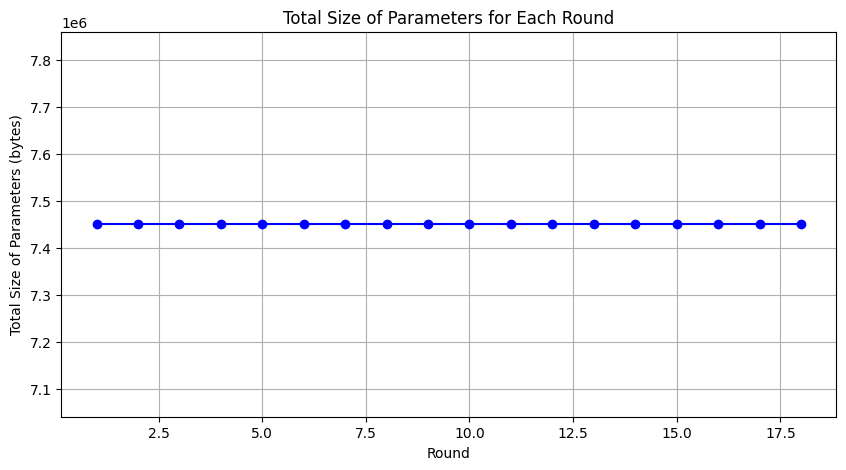

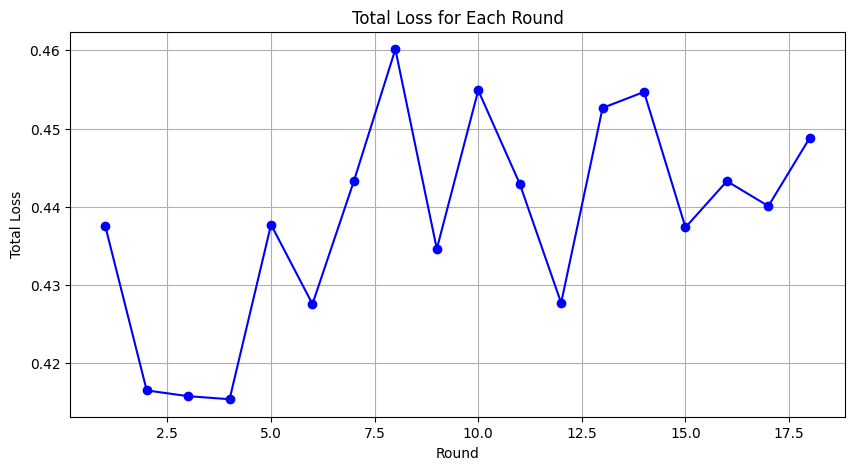

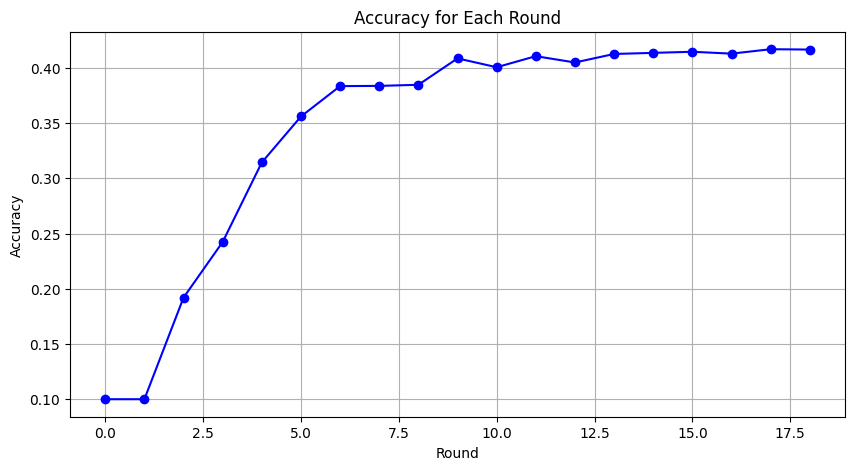

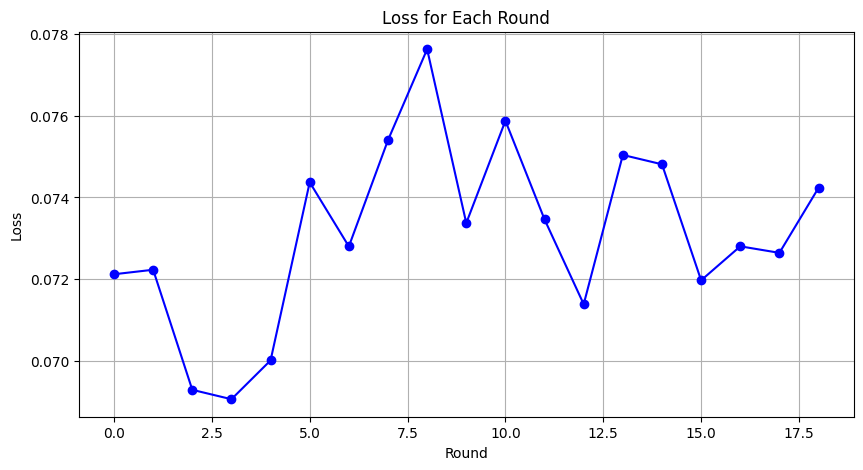

In [30]:
import matplotlib.pyplot as plt
import numpy as np


fed_avg_rounds = list(fed_avg_result.keys())
fed_avg_sizes = [fed_avg_result[round]["total_size"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Size of Parameters (bytes)')
plt.title('Total Size of Parameters for Each Round')
plt.grid(True)

fed_avg_losses = [fed_avg_result[round]["total_loss"] for round in fed_avg_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Total Loss')
plt.title('Total Loss for Each Round')
plt.grid(True)

fed_avg_model_rounds = list(fed_avg_model_results.keys())

fed_avg_accuracies = [fed_avg_model_results[round]["global_metrics"]["accuracy"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Round')
plt.grid(True)

fed_avg_global_losses = [fed_avg_model_results[round]["global_loss"] for round in fed_avg_model_rounds]

plt.figure(figsize=(10, 5))
plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Loss for Each Round')
plt.grid(True)

# FedProx experiments:

In [9]:
class FedProxFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")
        set_parameters(self.net, parameters)
        global_params = copy.deepcopy(self.net).parameters()
        proxima_train(self.net, self.trainloader, EPOCHS, config["proximal_mu"], global_params)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedProxFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

In [10]:
fed_prox_result = {}

fed_prox_model_results = {}

class ModifiedFedProx(ModifiedFedAvg):

    def __init__(
        self,
        *,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        proximal_mu: float,
    ) -> None:
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.proximal_mu = proximal_mu


    def __repr__(self) -> str:
        return "ModifiedFedProx"
    

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> list[tuple[ClientProxy, FitIns]]:
        """Configure the next round of training.

        Sends the proximal factor mu to the clients
        """
        # Get the standard client/config pairs from the FedAvg super-class
        client_config_pairs = super().configure_fit(
            server_round, parameters, client_manager
        )

        # Return client/config pairs with the proximal factor mu added
        return [
            (
                client,
                FitIns(
                    fit_ins.parameters,
                    {**fit_ins.config, "proximal_mu": self.proximal_mu},
                ),
            )
            for client, fit_ins in client_config_pairs
        ]
    
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) *2
        print(f"total size: {total_size}")
        
        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_size"] = total_size
        else:
            fed_prox_result[server_round] = {"total_size": total_size}
        

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]

        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}
        
        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss

        if fed_prox_result.get(server_round):
            fed_prox_result[server_round]["total_loss"] = total_loss
        else:
            fed_prox_result[server_round] = {"total_loss": total_loss}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated
    

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        
        if server_round in fed_prox_model_results:  
            expand_fed_prox_model_results= {**fed_prox_model_results[server_round], "global_loss": eval_res[0], "global_metrics": eval_res[1]}
        else:
            expand_fed_prox_model_results= {"global_loss": eval_res[0], "global_metrics": eval_res[1]}
        
        fed_prox_model_results[server_round] = expand_fed_prox_model_results
        
        loss, metrics = eval_res
        return loss, metrics


In [11]:
net = Net().to(DEVICE)

_, _, testloader = load_datasets(0, NUM_PARTITIONS)

evaluate_fn = get_evaluate_fn(testloader, net)


def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=ModifiedFedProx(proximal_mu=0.1, evaluate_fn=evaluate_fn),
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=18, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters



==== Server-side evaluation for round 0 ====


INFO :      initial parameters (loss, other metrics): 0.07212030863761902, {'accuracy': 0.1}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0721, Accuracy: 0.1000
(ClientAppActor pid=38036) [Client 1] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=38034) Epoch 1: train loss 0.05507439374923706, accuracy 0.3156727998226557
(ClientAppActor pid=38035) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=38036) Epoch 2: train loss 0.017538683488965034, accuracy 0.8119858989424207 [repeated 7x across cluster]
(ClientAppActor pid=38034) Epoch 5: train loss 0.037419237196445465, accuracy 0.5349146530702726 [repeated 10x across cluster]
(ClientAppActor pid=38031) Epoch 7: train loss 0.009469020180404186, accuracy 0.8914203612479474 [repeated 11x across cluster]
(ClientAppActor pid=38036) Epoch 7: train loss 0.012502122670412064, accuracy 0.8666274970622797 [repeated 9x across cluster]
(ClientAppActor pid=38032) Epoch 7: train loss 0.012806005775928497, accuracy 0.8643

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 1 ====
  Parameter 0: Changed by 0.024201
  Parameter 1: Changed by 0.033309
  Parameter 2: Changed by 0.019923
  Parameter 3: Changed by 0.028091
  Parameter 4: Changed by 0.014472
  Parameter 5: Changed by 0.020053
  Parameter 6: Changed by 0.010442
  Parameter 7: Changed by 0.030804
  Parameter 8: Changed by 0.009820
  Parameter 9: Changed by 0.031974
  Parameter 10: Changed by 0.007877
  Parameter 11: Changed by 0.030516
  Parameter 12: Changed by 0.006985
  Parameter 13: Changed by 0.026900
  Parameter 14: Changed by 0.047842
  Parameter 15: Changed by 0.038295


INFO :      fit progress: (1, 0.0726639177083969, {'accuracy': 0.1}, 47.30251358402893)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0727, Accuracy: 0.1000


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38037) [Client 0] evaluate, config: {}
(ClientAppActor pid=38037) Epoch 8: train loss 0.026305433362722397, accuracy 0.6630880579010856 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38037) [Client 1] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=38035) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=38035)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=38035) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38036) Epoch 1: train loss 0.020402440801262856, accuracy 0.7292692939244664
(ClientAppActor pid=38031) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38032) Epoch 3: train loss 0.03237013518810272, accuracy 0.634449124362669 [repeated 10x across cluster]
(ClientAppActor pid=38032) Epoch 5: train loss 0.027527177706360817, accuracy 0.6880957659055642 [repeated 7x across cluster]
(ClientAppActor pid=38031) Epoch 4: train loss 0.008312297984957695, accuracy 0.9029882452910353 [repeated 8x across cluster]
(ClientAppActor pid=38034) Epoch 5: train loss 0.011253931559622288, accuracy 0.8811494796594135 [repeated 10x across cluster]
(ClientAppActor pid=38037) Epoch 8: train loss 0.008293097838759422, accuracy 0.9112808460634547 [repeated 7x across cluster]
(ClientAppActor pid=38034) Epoch 8: train loss 0.007772781420499086, accuracy 0.9176

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 2 ====
  Parameter 0: Changed by 0.018582
  Parameter 1: Changed by 0.023071
  Parameter 2: Changed by 0.017996
  Parameter 3: Changed by 0.023878
  Parameter 4: Changed by 0.014120
  Parameter 5: Changed by 0.012862
  Parameter 6: Changed by 0.013273
  Parameter 7: Changed by 0.018300
  Parameter 8: Changed by 0.012825
  Parameter 9: Changed by 0.018615
  Parameter 10: Changed by 0.009410
  Parameter 11: Changed by 0.016499
  Parameter 12: Changed by 0.007202
  Parameter 13: Changed by 0.011890
  Parameter 14: Changed by 0.041267
  Parameter 15: Changed by 0.021844


INFO :      fit progress: (2, 0.06950620679855346, {'accuracy': 0.1716}, 92.30705962516367)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0695, Accuracy: 0.1716


(ClientAppActor pid=38034) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=38034)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=38034) [Client 1] evaluate, config: {}
(ClientAppActor pid=38035) Epoch 8: train loss 0.017253266647458076, accuracy 0.7965018094089265


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38031) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38031) Epoch 1: train loss 0.03567900136113167, accuracy 0.5867878519175349
(ClientAppActor pid=38032) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38035) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38031) Epoch 3: train loss 0.02414507232606411, accuracy 0.7286632675681667 [repeated 8x across cluster]
(ClientAppActor pid=38034) Epoch 5: train loss 0.006714488845318556, accuracy 0.9191297208538588 [repeated 11x across cluster]
(ClientAppActor pid=38034) Epoch 7: train loss 0.0044847698882222176, accuracy 0.9490968801313628 [repeated 9x across cluster]
(ClientAppActor pid=38032) Epoch 7: train loss 0.004841963294893503, accuracy 0.9484430082256169 [repeated 10x across cluster]
(ClientAppActor pid=38035) Epoch 7: train loss 0.004565385170280933, accuracy 0.9524597918637654 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 3 ====
  Parameter 0: Changed by 0.012136
  Parameter 1: Changed by 0.020102
  Parameter 2: Changed by 0.014525
  Parameter 3: Changed by 0.013815
  Parameter 4: Changed by 0.013169
  Parameter 5: Changed by 0.007735
  Parameter 6: Changed by 0.014768
  Parameter 7: Changed by 0.009630
  Parameter 8: Changed by 0.014687
  Parameter 9: Changed by 0.008002
  Parameter 10: Changed by 0.009389
  Parameter 11: Changed by 0.007304
  Parameter 12: Changed by 0.007410
  Parameter 13: Changed by 0.006785
  Parameter 14: Changed by 0.030441
  Parameter 15: Changed by 0.012971


INFO :      fit progress: (3, 0.06938837484121323, {'accuracy': 0.2284}, 134.27983316709287)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0694, Accuracy: 0.2284
(ClientAppActor pid=38036) [Client 1] evaluate, config: {}
(ClientAppActor pid=38035) Epoch 8: train loss 0.004044432658702135, accuracy 0.9590823084200568 [repeated 2x across cluster]


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38032) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38032)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38032) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38034) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38032) Epoch 1: train loss 0.031122205778956413, accuracy 0.6479716249168699
(ClientAppActor pid=38031) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38032) Epoch 3: train loss 0.018963558599352837, accuracy 0.7838616714697406 [repeated 8x across cluster]
(ClientAppActor pid=38036) Epoch 5: train loss 0.003913599532097578, accuracy 0.9560755336617406 [repeated 11x across cluster]
(ClientAppActor pid=38034) Epoch 4: train loss 0.012162024155259132, accuracy 0.8612786489746683 [repeated 8x across cluster]
(ClientAppActor pid=38037) Epoch 7: train loss 0.002805121708661318, accuracy 0.9713572267920094 [repeated 11x across cluster]
(ClientAppActor pid=38034) Epoch 7: train loss 0.006953984498977661, accuracy 0.9223160434258142 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 4 ====
  Parameter 0: Changed by 0.008876
  Parameter 1: Changed by 0.013673
  Parameter 2: Changed by 0.011355
  Parameter 3: Changed by 0.012262
  Parameter 4: Changed by 0.011544
  Parameter 5: Changed by 0.006959
  Parameter 6: Changed by 0.013445
  Parameter 7: Changed by 0.007032
  Parameter 8: Changed by 0.012865
  Parameter 9: Changed by 0.005274
  Parameter 10: Changed by 0.008393
  Parameter 11: Changed by 0.005088
  Parameter 12: Changed by 0.006568
  Parameter 13: Changed by 0.005086
  Parameter 14: Changed by 0.025512
  Parameter 15: Changed by 0.014596


INFO :      fit progress: (4, 0.0711249835729599, {'accuracy': 0.2768}, 180.96784912515432)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0711, Accuracy: 0.2768
(ClientAppActor pid=38031) [Client 0] evaluate, config: {}
(ClientAppActor pid=38031) Epoch 8: train loss 0.0024898191913962364, accuracy 0.972682119205298 [repeated 3x across cluster]


(ClientAppActor pid=38031) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38031)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38036) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38037) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38034) Epoch 1: train loss 0.01173575222492218, accuracy 0.8524220032840722
(ClientAppActor pid=38036) Epoch 1: train loss 0.014966540969908237, accuracy 0.8445945945945946
(ClientAppActor pid=38032) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38037) Epoch 2: train loss 0.014377485029399395, accuracy 0.8324487334137515 [repeated 11x across cluster]
(ClientAppActor pid=38037) Epoch 3: train loss 0.010694023221731186, accuracy 0.8814234016887816 [repeated 9x across cluster]
(ClientAppActor pid=38035) Epoch 7: train loss 0.004456028342247009, accuracy 0.9501219241853247 [repeated 7x across cluster]
(ClientAppActor pid=38037) Epoch 5: train loss 0.006734889931976795, accuracy 0.9260554885404101 [repeated 9x across cluster]
(ClientAppActor pid=38037) Epoch 7: train

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 5 ====
  Parameter 0: Changed by 0.007244
  Parameter 1: Changed by 0.014320
  Parameter 2: Changed by 0.009488
  Parameter 3: Changed by 0.009567
  Parameter 4: Changed by 0.010487
  Parameter 5: Changed by 0.005723
  Parameter 6: Changed by 0.011530
  Parameter 7: Changed by 0.007536
  Parameter 8: Changed by 0.010981
  Parameter 9: Changed by 0.004783
  Parameter 10: Changed by 0.007575
  Parameter 11: Changed by 0.005254
  Parameter 12: Changed by 0.005903
  Parameter 13: Changed by 0.004795
  Parameter 14: Changed by 0.024605
  Parameter 15: Changed by 0.017175


INFO :      fit progress: (5, 0.06866977677345276, {'accuracy': 0.3151}, 225.30815366702154)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0687, Accuracy: 0.3151


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=38037) [Client 1] evaluate, config: {}
(ClientAppActor pid=38032) Epoch 8: train loss 0.002401373814791441, accuracy 0.9730368968779565 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38034) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38034) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38031) Epoch 1: train loss 0.026545485481619835, accuracy 0.7036133894923521
(ClientAppActor pid=38037) Epoch 1: train loss 0.01076669991016388, accuracy 0.8647372742200329
(ClientAppActor pid=38036) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38034) Epoch 2: train loss 0.0031315323431044817, accuracy 0.9648774961053675 [repeated 9x across cluster]
(ClientAppActor pid=38036) Epoch 3: train loss 0.0034954226575791836, accuracy 0.961329233680227 [repeated 9x across cluster]
(ClientAppActor pid=38035) Epoch 4: train loss 0.006361858453601599, accuracy 0.9273823884197828 [repeated 10x across cluster]
(ClientAppActor pid=38032) Epoch 7: train loss 0.0017880565719678998, accuracy 0.982373678025852 [repeated 9x across cluster]
(ClientAppActor pid=38036) Epoch 8: trai

INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 6 ====
  Parameter 0: Changed by 0.005788
  Parameter 1: Changed by 0.007824
  Parameter 2: Changed by 0.008393
  Parameter 3: Changed by 0.010048
  Parameter 4: Changed by 0.009811
  Parameter 5: Changed by 0.005680
  Parameter 6: Changed by 0.010537
  Parameter 7: Changed by 0.007888
  Parameter 8: Changed by 0.010053
  Parameter 9: Changed by 0.005786
  Parameter 10: Changed by 0.007594
  Parameter 11: Changed by 0.006058
  Parameter 12: Changed by 0.005926
  Parameter 13: Changed by 0.005348
  Parameter 14: Changed by 0.026007
  Parameter 15: Changed by 0.018939


INFO :      fit progress: (6, 0.06840428844690323, {'accuracy': 0.3582}, 266.40059529198334)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0684, Accuracy: 0.3582
(ClientAppActor pid=38036) [Client 1] evaluate, config: {}
(ClientAppActor pid=38035) Epoch 8: train loss 0.0032095008064061403, accuracy 0.96562123039807


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38037) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38032) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38031) Epoch 1: train loss 0.009574297815561295, accuracy 0.8805418719211823
(ClientAppActor pid=38036) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38031) Epoch 3: train loss 0.003223876701667905, accuracy 0.9638752052545156 [repeated 8x across cluster]
(ClientAppActor pid=38037) Epoch 5: train loss 0.004802886862307787, accuracy 0.9490135225005542 [repeated 11x across cluster]
(ClientAppActor pid=38037) Epoch 7: train loss 0.002840624190866947, accuracy 0.9678563511416537 [repeated 10x across cluster]
(ClientAppActor pid=38032) Epoch 6: train loss 0.00409353245049715, accuracy 0.9574185765983112 [repeated 9x across cluster]
(ClientAppActor pid=38032) Epoch 8: train loss 0.002541136462241411, accuracy 0.9716525934861279 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 7 ====
  Parameter 0: Changed by 0.005499
  Parameter 1: Changed by 0.011521
  Parameter 2: Changed by 0.007901
  Parameter 3: Changed by 0.009196
  Parameter 4: Changed by 0.009278
  Parameter 5: Changed by 0.005506
  Parameter 6: Changed by 0.010198
  Parameter 7: Changed by 0.009080
  Parameter 8: Changed by 0.009685
  Parameter 9: Changed by 0.006163
  Parameter 10: Changed by 0.007202
  Parameter 11: Changed by 0.006265
  Parameter 12: Changed by 0.006186
  Parameter 13: Changed by 0.004778
  Parameter 14: Changed by 0.026398
  Parameter 15: Changed by 0.019313


INFO :      fit progress: (7, 0.07097545858621597, {'accuracy': 0.3665}, 309.16270362515934)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0710, Accuracy: 0.3665
(ClientAppActor pid=38036) [Client 0] evaluate, config: {}


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38036) Epoch 8: train loss 0.0013313572853803635, accuracy 0.9864001892147588


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38036) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38031) Epoch 1: train loss 0.009240311570465565, accuracy 0.8848522167487685
(ClientAppActor pid=38032) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38032) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38035) Epoch 3: train loss 0.007380486931651831, accuracy 0.9197517180226114 [repeated 9x across cluster]
(ClientAppActor pid=38031) Epoch 6: train loss 0.0017418548231944442, accuracy 0.9821428571428571 [repeated 13x across cluster]
(ClientAppActor pid=38035) Epoch 8: train loss 0.0028976029716432095, accuracy 0.9714032365329195 [repeated 11x across cluster]
(ClientAppActor pid=38037) Epoch 7: train loss 0.001215019030496478, accuracy 0.9873678025851939 [repeated 7x across cluster]
(ClientAppActor pid=38036) Epoch 8: train loss 0.0014185020700097084, accuracy 0.9856906338694418 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 8 ====
  Parameter 0: Changed by 0.004764
  Parameter 1: Changed by 0.009829
  Parameter 2: Changed by 0.007244
  Parameter 3: Changed by 0.007509
  Parameter 4: Changed by 0.009052
  Parameter 5: Changed by 0.006180
  Parameter 6: Changed by 0.009746
  Parameter 7: Changed by 0.007074
  Parameter 8: Changed by 0.009589
  Parameter 9: Changed by 0.006688
  Parameter 10: Changed by 0.007060
  Parameter 11: Changed by 0.005188
  Parameter 12: Changed by 0.005558
  Parameter 13: Changed by 0.004359
  Parameter 14: Changed by 0.028002
  Parameter 15: Changed by 0.019051


INFO :      fit progress: (8, 0.06867637445926666, {'accuracy': 0.385}, 348.63670433405787)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0687, Accuracy: 0.3850


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=38037) [Client 3] evaluate, config: {}
(ClientAppActor pid=38032) Epoch 8: train loss 0.0025772147346287966, accuracy 0.970928829915561


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38037) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38037) Epoch 1: train loss 0.008501434698700905, accuracy 0.8961412151067324
(ClientAppActor pid=38036) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38032) [Client 3] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38032) Epoch 3: train loss 0.006378313060849905, accuracy 0.9332742185768123 [repeated 8x across cluster]
(ClientAppActor pid=38036) Epoch 3: train loss 0.004070984199643135, accuracy 0.9547647768395657 [repeated 9x across cluster]
(ClientAppActor pid=38032) Epoch 8: train loss 0.002880791900679469, accuracy 0.9709598758590113 [repeated 12x across cluster]
(ClientAppActor pid=38036) Epoch 6: train loss 0.003085759934037924, accuracy 0.9662243667068757 [repeated 9x across cluster]
(ClientAppActor pid=38036) Epoch 8: train loss 0.0015946938656270504, accuracy 0.982509047044632 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 9 ====
  Parameter 0: Changed by 0.004608
  Parameter 1: Changed by 0.005655
  Parameter 2: Changed by 0.006970
  Parameter 3: Changed by 0.007869
  Parameter 4: Changed by 0.008828
  Parameter 5: Changed by 0.005780
  Parameter 6: Changed by 0.009483
  Parameter 7: Changed by 0.007322
  Parameter 8: Changed by 0.009589
  Parameter 9: Changed by 0.006484
  Parameter 10: Changed by 0.007416
  Parameter 11: Changed by 0.005227
  Parameter 12: Changed by 0.005692
  Parameter 13: Changed by 0.003945
  Parameter 14: Changed by 0.027413
  Parameter 15: Changed by 0.019925


INFO :      fit progress: (9, 0.06949630779027939, {'accuracy': 0.3944}, 389.36714916699566)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0695, Accuracy: 0.3944
(ClientAppActor pid=38031) [Client 1] evaluate, config: {}


(ClientAppActor pid=38031) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=38031)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=38031) Epoch 8: train loss 0.0011500976979732513, accuracy 0.9899479659413434


(ClientAppActor pid=38035) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=38035)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=38035) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38037) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38037) Epoch 1: train loss 0.020343173295259476, accuracy 0.7765462203502549
(ClientAppActor pid=38032) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 4x across cluster]
(ClientAppActor pid=38032) Epoch 2: train loss 0.0013948959531262517, accuracy 0.9852712080441863 [repeated 8x across cluster]


(ClientAppActor pid=38031) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38031)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38031) [Client 5] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38037) Epoch 6: train loss 0.003568672575056553, accuracy 0.9634227444025715 [repeated 10x across cluster]
(ClientAppActor pid=38032) Epoch 5: train loss 0.00089932611444965, accuracy 0.9899447670301657 [repeated 10x across cluster]
(ClientAppActor pid=38034) Epoch 7: train loss 0.0017337569734081626, accuracy 0.9822267920094007 [repeated 7x across cluster]
(ClientAppActor pid=38035) Epoch 8: train loss 0.0037751623895019293, accuracy 0.9613992762364294 [repeated 11x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 10 ====
  Parameter 0: Changed by 0.004269
  Parameter 1: Changed by 0.007778
  Parameter 2: Changed by 0.007123
  Parameter 3: Changed by 0.006757
  Parameter 4: Changed by 0.008741
  Parameter 5: Changed by 0.005036
  Parameter 6: Changed by 0.009349
  Parameter 7: Changed by 0.006225
  Parameter 8: Changed by 0.009364
  Parameter 9: Changed by 0.006457
  Parameter 10: Changed by 0.007419
  Parameter 11: Changed by 0.005802
  Parameter 12: Changed by 0.005529
  Parameter 13: Changed by 0.004820
  Parameter 14: Changed by 0.028428
  Parameter 15: Changed by 0.018311


INFO :      fit progress: (10, 0.06992963299751281, {'accuracy': 0.4007}, 435.38469720911235)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0699, Accuracy: 0.4007
(ClientAppActor pid=38036) [Client 0] evaluate, config: {}
(ClientAppActor pid=38036) Epoch 8: train loss 0.0010113402968272567, accuracy 0.989356669820246


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=38035) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38035)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=38032) [Client 3] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38036) [Client 5] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=38031) [Client 2] evaluate, config: {}
(ClientAppActor pid=38036) Epoch 1: train loss 0.007793943397700787, accuracy 0.9066091954022989
(ClientAppActor pid=38035) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38031) Epoch 2: train loss 0.0033639888279139996, accuracy 0.9641737032569361 [repeated 12x across cluster]
(ClientAppActor pid=38034) Epoch 6: train loss 0.0018887730548158288, accuracy 0.9760585236089558 [repeated 10x across cluster]
(ClientAppActor pid=38031) Epoch 5: train loss 0.0024914268869906664, accuracy 0.9714113389626056 [repeated 12x across cluster]
(ClientAppActor pid=38032) Epoch 8: train loss 0.0015583966160193086, accuracy 0.9854582843713279 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 11 ====
  Parameter 0: Changed by 0.003959
  Parameter 1: Changed by 0.008670
  Parameter 2: Changed by 0.006655
  Parameter 3: Changed by 0.007040
  Parameter 4: Changed by 0.008723
  Parameter 5: Changed by 0.005406
  Parameter 6: Changed by 0.009382
  Parameter 7: Changed by 0.006094
  Parameter 8: Changed by 0.009309
  Parameter 9: Changed by 0.006632
  Parameter 10: Changed by 0.007684
  Parameter 11: Changed by 0.005249
  Parameter 12: Changed by 0.006284
  Parameter 13: Changed by 0.005090
  Parameter 14: Changed by 0.031105
  Parameter 15: Changed by 0.017851


INFO :      fit progress: (11, 0.06670669531822204, {'accuracy': 0.4079}, 478.8456505420618)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0667, Accuracy: 0.4079


(ClientAppActor pid=38034) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38034)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38034) [Client 5] evaluate, config: {}
(ClientAppActor pid=38035) Epoch 8: train loss 0.0012192969443276525, accuracy 0.9885288552507095 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38037) [Client 1] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=38034) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=38034)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]


(ClientAppActor pid=38036) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38031) Epoch 1: train loss 0.018492449074983597, accuracy 0.8011527377521613
(ClientAppActor pid=38032) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 4x across cluster]
(ClientAppActor pid=38034) Epoch 3: train loss 0.001540622441098094, accuracy 0.9811165845648604 [repeated 9x across cluster]


(ClientAppActor pid=38035) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=38035)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=38035) [Client 2] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38036) Epoch 3: train loss 0.002827621065080166, accuracy 0.9689987937273824 [repeated 8x across cluster]
(ClientAppActor pid=38035) Epoch 2: train loss 0.0014332900755107403, accuracy 0.9848463390454609 [repeated 11x across cluster]
(ClientAppActor pid=38036) Epoch 6: train loss 0.0018425737507641315, accuracy 0.9804583835946924 [repeated 8x across cluster]
(ClientAppActor pid=38035) Epoch 6: train loss 0.0006845613243058324, accuracy 0.9926356040220932 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 12 ====
  Parameter 0: Changed by 0.003876
  Parameter 1: Changed by 0.006049
  Parameter 2: Changed by 0.006713
  Parameter 3: Changed by 0.009645
  Parameter 4: Changed by 0.008798
  Parameter 5: Changed by 0.005638
  Parameter 6: Changed by 0.009349
  Parameter 7: Changed by 0.007462
  Parameter 8: Changed by 0.009335
  Parameter 9: Changed by 0.006545
  Parameter 10: Changed by 0.007582
  Parameter 11: Changed by 0.005551
  Parameter 12: Changed by 0.005953
  Parameter 13: Changed by 0.004698
  Parameter 14: Changed by 0.028576
  Parameter 15: Changed by 0.017480


INFO :      fit progress: (12, 0.06585300199985504, {'accuracy': 0.3983}, 520.0606654169969)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0659, Accuracy: 0.3983


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=38032) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38032)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=38037) [Client 3] evaluate, config: {}
(ClientAppActor pid=38035) Epoch 8: train loss 0.0008997789118438959, accuracy 0.990369636028891 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38031) [Client 2] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=38035) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38034) Epoch 1: train loss 0.01766449399292469, accuracy 0.8089115495455553
(ClientAppActor pid=38037) [Client 5] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38032) Epoch 2: train loss 0.001206675311550498, accuracy 0.9881740775780511 [repeated 11x across cluster]
(ClientAppActor pid=38034) Epoch 7: train loss 0.0012143057538196445, accuracy 0.9866991797827532 [repeated 14x across cluster]
(ClientAppActor pid=38032) Epoch 5: train loss 0.0010607513831928372, accuracy 0.9897114474929044 [repeated 11x across cluster]
(ClientAppActor pid=38031) Epoch 8: train loss 0.0004965988337062299, accuracy 0.9951848180144456 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 13 ====
  Parameter 0: Changed by 0.003706
  Parameter 1: Changed by 0.007514
  Parameter 2: Changed by 0.006692
  Parameter 3: Changed by 0.008172
  Parameter 4: Changed by 0.008592
  Parameter 5: Changed by 0.005673
  Parameter 6: Changed by 0.009201
  Parameter 7: Changed by 0.006145
  Parameter 8: Changed by 0.009331
  Parameter 9: Changed by 0.008046
  Parameter 10: Changed by 0.007824
  Parameter 11: Changed by 0.005701
  Parameter 12: Changed by 0.006532
  Parameter 13: Changed by 0.005221
  Parameter 14: Changed by 0.030381
  Parameter 15: Changed by 0.015912


INFO :      fit progress: (13, 0.07009207136631011, {'accuracy': 0.4123}, 556.0476867090911)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0701, Accuracy: 0.4123
(ClientAppActor pid=38036) [Client 3] evaluate, config: {}
(ClientAppActor pid=38032) Epoch 8: train loss 0.0009053542744368315, accuracy 0.9914853358561968 [repeated 4x across cluster]


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=38031) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38031)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38034) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38035) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38036) Epoch 1: train loss 0.00626850500702858, accuracy 0.9293924466338259 [repeated 2x across cluster]


(ClientAppActor pid=38035) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 9x across cluster]
(ClientAppActor pid=38035)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 9x across cluster]


(ClientAppActor pid=38032) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38034) Epoch 4: train loss 0.003061769064515829, accuracy 0.9654178674351584 [repeated 8x across cluster]
(ClientAppActor pid=38036) Epoch 6: train loss 0.0007945100078359246, accuracy 0.9895320197044335 [repeated 12x across cluster]
(ClientAppActor pid=38037) Epoch 5: train loss 0.001986395800486207, accuracy 0.9792521109770809 [repeated 11x across cluster]
(ClientAppActor pid=38032) Epoch 6: train loss 0.0010667608585208654, accuracy 0.9898031440305906 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 14 ====
  Parameter 0: Changed by 0.004031
  Parameter 1: Changed by 0.008047
  Parameter 2: Changed by 0.006828
  Parameter 3: Changed by 0.005767
  Parameter 4: Changed by 0.008564
  Parameter 5: Changed by 0.005397
  Parameter 6: Changed by 0.009098
  Parameter 7: Changed by 0.007299
  Parameter 8: Changed by 0.009310
  Parameter 9: Changed by 0.008361
  Parameter 10: Changed by 0.007833
  Parameter 11: Changed by 0.005139
  Parameter 12: Changed by 0.006351
  Parameter 13: Changed by 0.004875
  Parameter 14: Changed by 0.028479
  Parameter 15: Changed by 0.016201
(ClientAppActor pid=38032) Epoch 8: train loss 0.0005276359734125435, accuracy 0.9950431950148704 [repeated 7x across cluster]


INFO :      fit progress: (14, 0.06765487068295478, {'accuracy': 0.4169}, 591.824027917115)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0677, Accuracy: 0.4169
(ClientAppActor pid=38036) [Client 4] evaluate, config: {}


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=38031) Epoch 8: train loss 0.0010203280253335834, accuracy 0.9899479659413434
(ClientAppActor pid=38031) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=38031) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=38031)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38037) [Client 3] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38037) Epoch 1: train loss 0.015981430187821388, accuracy 0.8286410995344713
(ClientAppActor pid=38031) [Client 0] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38036) Epoch 2: train loss 0.0013465669471770525, accuracy 0.9873462630085147 [repeated 12x across cluster]
(ClientAppActor pid=38035) Epoch 6: train loss 0.000683983787894249, accuracy 0.9926108374384236 [repeated 13x across cluster]
(ClientAppActor pid=38032) Epoch 6: train loss 0.0009629483101889491, accuracy 0.9903055229142186 [repeated 9x across cluster]
(ClientAppActor pid=38032) Epoch 8: train loss 0.0009400389390066266, accuracy 0.9903055229142186 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 15 ====
  Parameter 0: Changed by 0.004115
  Parameter 1: Changed by 0.007575
  Parameter 2: Changed by 0.006800
  Parameter 3: Changed by 0.006166
  Parameter 4: Changed by 0.008704
  Parameter 5: Changed by 0.005105
  Parameter 6: Changed by 0.009352
  Parameter 7: Changed by 0.006887
  Parameter 8: Changed by 0.009598
  Parameter 9: Changed by 0.007924
  Parameter 10: Changed by 0.008104
  Parameter 11: Changed by 0.006426
  Parameter 12: Changed by 0.006689
  Parameter 13: Changed by 0.005374
  Parameter 14: Changed by 0.029826
  Parameter 15: Changed by 0.015764


INFO :      fit progress: (15, 0.06681523315906525, {'accuracy': 0.4197}, 632.4109143340029)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0668, Accuracy: 0.4197


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=38037) [Client 5] evaluate, config: {}
(ClientAppActor pid=38031) Epoch 8: train loss 0.0018835349474102259, accuracy 0.9806996381182147 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38036) [Client 1] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38035) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38034) Epoch 1: train loss 0.015446983277797699, accuracy 0.8339614276213699
(ClientAppActor pid=38032) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38037) Epoch 3: train loss 0.0007944318931549788, accuracy 0.9901477832512315 [repeated 10x across cluster]
(ClientAppActor pid=38035) Epoch 3: train loss 0.002157100010663271, accuracy 0.9758745476477684 [repeated 13x across cluster]
(ClientAppActor pid=38036) Epoch 6: train loss 0.0007242633146233857, accuracy 0.992508813160987 [repeated 10x across cluster]
(ClientAppActor pid=38032) Epoch 7: train loss 0.0007343271281570196, accuracy 0.9929188500212435 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=38035) Epoch 8: train loss 0.0014357577310875058, accuracy 0.9841978287092883 [repeated 6x across cluster]
total size: 7449672

==== Server-side evaluation for round 16 ====
  Parameter 0: Changed by 0.003769
  Parameter 1: Changed by 0.004837
  Parameter 2: Changed by 0.006818
  Parameter 3: Changed by 0.008782
  Parameter 4: Changed by 0.008707
  Parameter 5: Changed by 0.005535
  Parameter 6: Changed by 0.009292
  Parameter 7: Changed by 0.006795
  Parameter 8: Changed by 0.009321
  Parameter 9: Changed by 0.009665
  Parameter 10: Changed by 0.008307
  Parameter 11: Changed by 0.007266
  Parameter 12: Changed by 0.007105
  Parameter 13: Changed by 0.005447
  Parameter 14: Changed by 0.030686
  Parameter 15: Changed by 0.015494


INFO :      fit progress: (16, 0.06833641984462738, {'accuracy': 0.4125}, 672.4146306251641)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0683, Accuracy: 0.4125


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38037) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38031) [Client 4] fit, config: {'proximal_mu': 0.1}
(ClientAppActor pid=38034) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=38031) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38031)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=38035) Epoch 1: train loss 0.015047118067741394, accuracy 0.8357348703170029
(ClientAppActor pid=38032) [Client 2] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38031) Epoch 2: train loss 0.0012369649484753609, accuracy 0.9875827814569537 [repeated 12x across cluster]
(ClientAppActor pid=38032) Epoch 4: train loss 0.00040479551535099745, accuracy 0.995609687013171 [repeated 12x across cluster]
(ClientAppActor pid=38036) Epoch 6: train loss 0.0007782548200339079, accuracy 0.9917743830787309 [repeated 10x across cluster]
(ClientAppActor pid=38036) Epoch 8: train loss 0.0007096777553670108, accuracy 0.9928025851938895 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 17 ====
  Parameter 0: Changed by 0.003986
  Parameter 1: Changed by 0.008208
  Parameter 2: Changed by 0.007016
  Parameter 3: Changed by 0.006618
  Parameter 4: Changed by 0.008612
  Parameter 5: Changed by 0.005295
  Parameter 6: Changed by 0.009192
  Parameter 7: Changed by 0.007630
  Parameter 8: Changed by 0.009567
  Parameter 9: Changed by 0.008376
  Parameter 10: Changed by 0.008653
  Parameter 11: Changed by 0.008091
  Parameter 12: Changed by 0.007164
  Parameter 13: Changed by 0.004964
  Parameter 14: Changed by 0.029175
  Parameter 15: Changed by 0.014528


INFO :      fit progress: (17, 0.06976803967952729, {'accuracy': 0.4114}, 711.9139427500777)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0698, Accuracy: 0.4114
(ClientAppActor pid=38036) [Client 3] evaluate, config: {}
(ClientAppActor pid=38031) Epoch 8: train loss 0.0010431825648993254, accuracy 0.9900662251655629 [repeated 5x across cluster]


(ClientAppActor pid=38036) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=38036)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=38031) [Client 0] fit, config: {'proximal_mu': 0.1}


(ClientAppActor pid=38035) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=38035)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=38031) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38036) Epoch 1: train loss 0.0055315736681222916, accuracy 0.9382183908045977
(ClientAppActor pid=38035) [Client 4] fit, config: {'proximal_mu': 0.1} [repeated 5x across cluster]
(ClientAppActor pid=38032) Epoch 4: train loss 0.0026335115544497967, accuracy 0.9718465972068278 [repeated 13x across cluster]
(ClientAppActor pid=38032) Epoch 7: train loss 0.002711569657549262, accuracy 0.9729549988915983 [repeated 13x across cluster]
(ClientAppActor pid=38037) Epoch 6: train loss 0.000523016438819468, accuracy 0.9937685880186943 [repeated 10x across cluster]
(ClientAppActor pid=38034) Epoch 8: train loss 0.00078264792682603, accuracy 0.9929494712103408 [repeated 6x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


total size: 7449672

==== Server-side evaluation for round 18 ====
  Parameter 0: Changed by 0.003462
  Parameter 1: Changed by 0.004944
  Parameter 2: Changed by 0.006904
  Parameter 3: Changed by 0.005457
  Parameter 4: Changed by 0.008794
  Parameter 5: Changed by 0.005530
  Parameter 6: Changed by 0.009337
  Parameter 7: Changed by 0.007536
  Parameter 8: Changed by 0.009580
  Parameter 9: Changed by 0.010954
  Parameter 10: Changed by 0.008752
  Parameter 11: Changed by 0.009340
  Parameter 12: Changed by 0.007802
  Parameter 13: Changed by 0.006468
  Parameter 14: Changed by 0.030671
  Parameter 15: Changed by 0.015635


INFO :      fit progress: (18, 0.06422138367891311, {'accuracy': 0.4142}, 748.6981230000965)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0642, Accuracy: 0.4142


(ClientAppActor pid=38032) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38032)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=38035) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=38035)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=38032) [Client 5] evaluate, config: {}
(ClientAppActor pid=38035) Epoch 8: train loss 0.0006783180288039148, accuracy 0.9940870387890255 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 18 round(s) in 752.12s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07352979700020199
INFO :      		round 2: 0.07032448437839851
INFO :      		round 3: 0.07031452046146124
INFO :      		round 4: 0.0722875934268214
INFO :      		round 5: 0.0691451024462584
INFO :      		round 6: 0.0687092281066081
INFO :      		round 7: 0.0716160540188217
INFO :      		round 8: 0.06892292475631864
INFO :      		round 9: 0.06955741644547542
INFO :      		round 10: 0.07048217831086685
INFO :      		round 11: 0.06720187142380342
INFO :      		round 12: 0.06648232469827753
INFO :      		round 13: 0.07096756019714413
INFO :      		round 14: 0.06835309375680859
INFO :      		round 15: 0.06751436224538777
INFO :      		round 16: 0.06811977096211748
INFO :      		round 17: 0.07015342529337991
INFO :      		round 18: 0.06457155379709986
INFO :      	History (loss, ce

(ClientAppActor pid=38037) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=38037) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=38037)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


In [12]:
with open(f'results/fed_prox_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_prox_result, file)

with open(f'results/fed_prox_data_heterogenity_model_results.p', 'wb') as file:
    pickle.dump(fed_prox_model_results, file)

In [16]:
fed_prox_rounds = list(fed_prox_result.keys())
fed_prox_sizes = [fed_prox_result[round]["total_size"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Size of Parameters (bytes)')
# plt.title('Total Size of Parameters for Each Round')
# plt.legend()
# plt.grid(True)

# fed_prox_losses = [fed_prox_result[round]["total_loss"] for round in fed_prox_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='b', label='FedProx')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Total Loss')
# plt.title('Total Loss for Each Round')
# plt.legend()
# plt.grid(True)


# fed_prox_model_rounds = list(fed_prox_model_results.keys())
# fed_prox_accuracies = [fed_prox_model_results[round]["global_metrics"]["accuracy"] for round in fed_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# # plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

# fed_prox_global_losses = [fed_prox_model_results[round]["global_loss"] for round in fed_prox_model_rounds]

# plt.figure(figsize=(10, 5))
# # plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='b', label='FedPartProx')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')   
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='g', label='FedAvg')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Loss for Each Round')
# plt.legend()
# plt.grid(True)


# FedMoon experiments:

In [17]:
class FedMoonNoFreezeFlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.model_dir = "models"

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        parameters = get_parameters(self.net)
        trainable_layer = config["trainable_layers"]
        self._save_model_state()
        
        if trainable_layer == -1:
            return parameters
        
        trained_layer = [parameters[trainable_layer*2], parameters[trainable_layer*2 +1]]
        return trained_layer

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id}] fit, config: {config}")

        # load previous model
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            prev_model = copy.deepcopy(self.net)
        else:
            # initialise and load params from model_dir
            prev_model = type(self.net)() 
            prev_model.load_state_dict(
                torch.load(
                    os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt")
                )
            )

        # update params for current model (loading global params)
        set_parameters(self.net, parameters)

        # create global model (same params that were just loaded)
        global_model = type(self.net)()
        global_model.load_state_dict(self.net.state_dict())
        global_model.to(DEVICE)
        
        train_moon(self.net, self.trainloader, global_model, prev_model, EPOCHS, 5, 0.5)

        # save current model 
        if not os.path.exists(os.path.join(self.model_dir, str(self.partition_id))):
            os.makedirs(os.path.join(self.model_dir, str(self.partition_id)))
        torch.save(
            self.net.state_dict(),
            os.path.join(self.model_dir, str(self.partition_id), "prev_net.pt"),
        )

        return get_parameters(self.net), len(self.trainloader), {}


    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test_moon(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = MoonNet().to(DEVICE)
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FedMoonNoFreezeFlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)


In [18]:
from typing import Union
import sys

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg

def get_parameters_size(params: Parameters) -> int:
    size = sys.getsizeof(params)  # Base size of the dataclass instance
    size += sys.getsizeof(params.tensor_type)  # Size of the string
    size += sys.getsizeof(params.tensors)  # Size of the list container
    size += sum(sys.getsizeof(tensor) for tensor in params.tensors)  # Size of each bytes object
    return size

fed_moon_no_freeze_result = {}
fed_moon_model_no_freeze_results = {}

# basically same as normal FedAvg, just added freezing and modified result dict names
class FedMoonNoFreeze(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[
                [int, NDArrays, dict[str, Scalar]],
                Optional[tuple[float, dict[str, Scalar]]],
            ]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        inplace: bool = True,
        layer_update_strategy: str = "sequential",
        
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.evaluate_fn = evaluate_fn
        self.on_fit_config_fn = on_fit_config_fn
        self.on_evaluate_config_fn = on_evaluate_config_fn
        self.accept_failures = accept_failures
        self.initial_parameters = initial_parameters
        self.fit_metrics_aggregation_fn = fit_metrics_aggregation_fn
        self.evaluate_metrics_aggregation_fn = evaluate_metrics_aggregation_fn
        self.inplace = inplace
        self.layer_training_sequence = []
        self.training_sequence_index = 0
        self.latest_parameters = initial_parameters


    def __repr__(self) -> str:
        return "FedMoon"
    
    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients
   
    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = MoonNet()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[tuple[float, dict[str, Scalar]]]:
        """Evaluate model parameters using an evaluation function."""
        if self.evaluate_fn is None:
            # No evaluation function provided
            return None
        parameters_ndarrays = parameters_to_ndarrays(parameters)
        eval_res = self.evaluate_fn(server_round, parameters_ndarrays, {})
        if eval_res is None:
            return None
        loss, metrics = eval_res

        if server_round in fed_moon_model_no_freeze_results:
            expand_fed_moon_no_freeze_result= {**fed_moon_model_no_freeze_results[server_round], "global_loss": loss, "global_metrics": metrics}
        else:
            expand_fed_moon_no_freeze_result= {"global_loss": loss, "global_metrics": metrics}

        fed_moon_model_no_freeze_results[server_round] = expand_fed_moon_no_freeze_result

        return loss, metrics


    def configure_fit(
        # includes layer freezing
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:
        """Configure the next round of training."""
        config = {}
        
        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )
        
        fit_configurations = []
        for idx, client in enumerate(clients):
            fit_configurations.append((client, FitIns(parameters, config)))

        self.training_sequence_index = self.training_sequence_index + 1
        
        return fit_configurations
    
    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]


    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""

        # get size of parameters in bytes
        total_size = 0
        for client, fit_res in results:
            total_size += get_parameters_size(fit_res.parameters) * 2
        
        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_size": total_size}
        else:
            expand_fed_moon_no_freeze_result= {"total_size": total_size}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        
        aggregated_weights = aggregate(weights_results)
        
        self.latest_parameters = ndarrays_to_parameters(aggregated_weights)

        metrics_aggregated = {}
        return self.latest_parameters, metrics_aggregated

    

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        total_loss = 0
        for _, evaluate_res in results:
            total_loss += evaluate_res.loss 


        if server_round in fed_moon_no_freeze_result:
            expand_fed_moon_no_freeze_result= {**fed_moon_no_freeze_result[server_round], "total_loss": total_loss}
        else:
            expand_fed_moon_no_freeze_result= {"total_loss": total_loss}

        fed_moon_no_freeze_result[server_round] = expand_fed_moon_no_freeze_result

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

In [19]:
# Train FedMOON


_, _, testloader = load_datasets(0, NUM_PARTITIONS)
net = MoonNet().to(DEVICE)
evaluate_fn = get_evaluate_fn_moon(testloader, net)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=NUM_OF_ROUNDS)
    return ServerAppComponents(
        config=config,
        strategy=FedMoonNoFreeze(
            evaluate_fn=evaluate_fn
        )
    )

server = ServerApp(server_fn=server_fn)

# Run simulation
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config=backend_config,
)

/Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      Starting Flower ServerApp, config: num_rounds=18, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters



==== Server-side evaluation for round 0 ====


INFO :      initial parameters (loss, other metrics): 0.07212370393276214, {'accuracy': 0.1227}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0721, Accuracy: 0.1227


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80940) [Client 3] fit, config: {}
(ClientAppActor pid=80940) Started training moon
(ClientAppActor pid=80940) Epoch: 0 Loss: 2.841390 Loss1: 1.863587 Loss2: 0.977803
(ClientAppActor pid=80937) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80937) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80942) Epoch: 1 Loss: 1.668293 Loss1: 0.585214 Loss2: 1.083079 [repeated 9x across cluster]
(ClientAppActor pid=80937) Epoch: 3 Loss: 1.324318 Loss1: 0.362352 Loss2: 0.961967 [repeated 9x across cluster]
(ClientAppActor pid=80942) Epoch: 4 Loss: 1.536908 Loss1: 0.459248 Loss2: 1.077660 [repeated 9x across cluster]
(ClientAppActor pid=80939) Epoch: 4 Loss: 1.690570 Loss1: 0.513059 Loss2: 1.177512 [repeated 10x across cluster]
(ClientAppActor pid=80943) Epoch: 6 Loss: 1.965279 Loss1: 0.932550 Loss2: 1.032730 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 1 ====
  Parameter 0: Changed by 0.023189
  Parameter 1: Changed by 0.045371
  Parameter 2: Changed by 0.020891
  Parameter 3: Changed by 0.031905
  Parameter 4: Changed by 0.014263
  Parameter 5: Changed by 0.017631
  Parameter 6: Changed by 0.010386
  Parameter 7: Changed by 0.026677
  Parameter 8: Changed by 0.010606
  Parameter 9: Changed by 0.024078
  Parameter 10: Changed by 0.008539
  Parameter 11: Changed by 0.014802
  Parameter 12: Changed by 0.007917
  Parameter 13: Changed by 0.014044
  Parameter 14: Changed by 0.020837
  Parameter 15: Changed by 0.037857


INFO :      fit progress: (1, 0.07250844559669495, {'accuracy': 0.1}, 47.95829387498088)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0725, Accuracy: 0.1000
(ClientAppActor pid=80939) [Client 0] evaluate, config: {}
(ClientAppActor pid=80939) Epoch: 7 Loss: 1.573335 Loss1: 0.397458 Loss2: 1.175877 [repeated 3x across cluster]


(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80943) [Client 2] fit, config: {}
(ClientAppActor pid=80943) Started training moon
(ClientAppActor pid=80941) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80937) Epoch: 0 Loss: 3.217865 Loss1: 1.551853 Loss2: 1.666011
(ClientAppActor pid=80942) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80942) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 1 Loss: 2.569937 Loss1: 0.645575 Loss2: 1.924362 [repeated 11x across cluster]
(ClientAppActor pid=80937) Epoch: 5 Loss: 2.540799 Loss1: 0.941880 Loss2: 1.598919 [repeated 10x across cluster]
(ClientAppActor pid=80940) Epoch: 7 Loss: 2.154403 Loss1: 0.249943 Loss2: 1.904460 [repeated 11x across cluster]
(ClientAppActor pid=80939) Epoch: 5 Loss: 2.356920 Loss1: 0.447831 Loss2: 1.909090 [repeated 7x across cluster]
(ClientAppActor pid=80939) Epoch: 7 Loss: 2.308605 Loss1: 0.401206 Loss2: 1.907399 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 2 ====
  Parameter 0: Changed by 0.018865
  Parameter 1: Changed by 0.036660
  Parameter 2: Changed by 0.019557
  Parameter 3: Changed by 0.027615
  Parameter 4: Changed by 0.012959
  Parameter 5: Changed by 0.016636
  Parameter 6: Changed by 0.011743
  Parameter 7: Changed by 0.026323
  Parameter 8: Changed by 0.012317
  Parameter 9: Changed by 0.020637
  Parameter 10: Changed by 0.008203
  Parameter 11: Changed by 0.014376
  Parameter 12: Changed by 0.004585
  Parameter 13: Changed by 0.011117
  Parameter 14: Changed by 0.021272
  Parameter 15: Changed by 0.031672


INFO :      fit progress: (2, 0.0736592470407486, {'accuracy': 0.1032}, 89.98625887511298)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0737, Accuracy: 0.1032


(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=80937) [Client 5] evaluate, config: {}
(ClientAppActor pid=80941) Epoch: 7 Loss: 2.414439 Loss1: 0.724169 Loss2: 1.690270


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80941) [Client 1] fit, config: {}
(ClientAppActor pid=80941) Started training moon
(ClientAppActor pid=80942) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=80937) Epoch: 0 Loss: 1.626479 Loss1: 0.491013 Loss2: 1.135466


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80940) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80940) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80940) Epoch: 0 Loss: 2.386460 Loss1: 1.307647 Loss2: 1.078813 [repeated 7x across cluster]
(ClientAppActor pid=80937) Epoch: 4 Loss: 1.300464 Loss1: 0.229711 Loss2: 1.070753 [repeated 10x across cluster]
(ClientAppActor pid=80941) Epoch: 4 Loss: 1.366846 Loss1: 0.275983 Loss2: 1.090863 [repeated 8x across cluster]
(ClientAppActor pid=80942) Epoch: 4 Loss: 1.796954 Loss1: 0.667614 Loss2: 1.129340 [repeated 10x across cluster]
(ClientAppActor pid=80943) Epoch: 5 Loss: 1.301571 Loss1: 0.282879 Loss2: 1.018691 [repeated 6x across cluster]
(ClientAppActor pid=80942) Epoch: 7 Loss: 1.570655 Loss1: 0.441084 Loss2: 1.129572 [repeated 5x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 3 ====
  Parameter 0: Changed by 0.014835
  Parameter 1: Changed by 0.021466
  Parameter 2: Changed by 0.017473
  Parameter 3: Changed by 0.020323
  Parameter 4: Changed by 0.013481
  Parameter 5: Changed by 0.010783
  Parameter 6: Changed by 0.015609
  Parameter 7: Changed by 0.022155
  Parameter 8: Changed by 0.017756
  Parameter 9: Changed by 0.016378
  Parameter 10: Changed by 0.009752
  Parameter 11: Changed by 0.011608
  Parameter 12: Changed by 0.003681
  Parameter 13: Changed by 0.007422
  Parameter 14: Changed by 0.013484
  Parameter 15: Changed by 0.015864


INFO :      fit progress: (3, 0.0801055318593979, {'accuracy': 0.2343}, 138.790413208073)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0801, Accuracy: 0.2343


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80940) [Client 4] evaluate, config: {}
(ClientAppActor pid=80943) Epoch: 7 Loss: 1.218940 Loss1: 0.200563 Loss2: 1.018377


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80943) [Client 1] fit, config: {}
(ClientAppActor pid=80943) Started training moon
(ClientAppActor pid=80942) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80940) Epoch: 0 Loss: 2.640086 Loss1: 1.085238 Loss2: 1.554848


(ClientAppActor pid=80942) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80942)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80942) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80942) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80940) Epoch: 2 Loss: 2.121244 Loss1: 0.727132 Loss2: 1.394112 [repeated 7x across cluster]
(ClientAppActor pid=80940) Epoch: 4 Loss: 1.908842 Loss1: 0.518601 Loss2: 1.390241 [repeated 9x across cluster]
(ClientAppActor pid=80940) Epoch: 6 Loss: 1.742897 Loss1: 0.352225 Loss2: 1.390672 [repeated 9x across cluster]
(ClientAppActor pid=80942) Epoch: 3 Loss: 1.754290 Loss1: 0.507396 Loss2: 1.246894 [repeated 8x across cluster]
(ClientAppActor pid=80942) Epoch: 4 Loss: 1.670550 Loss1: 0.424417 Loss2: 1.246133 [repeated 4x across cluster]
(ClientAppActor pid=80943) Epoch: 7 Loss: 1.486436 Loss1: 0.092632 Loss2: 1.393804 [repeated 4x across cluster]
(ClientAppActor pid=80942) Epoch: 6 Loss: 1.542351 Loss1: 0.297087 Loss2: 1.245264 [repeated 4x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80942) Epoch: 7 Loss: 1.482069 Loss1: 0.237922 Loss2: 1.244147 [repeated 2x across cluster]

==== Server-side evaluation for round 4 ====
  Parameter 0: Changed by 0.010660
  Parameter 1: Changed by 0.017295
  Parameter 2: Changed by 0.012723
  Parameter 3: Changed by 0.016755
  Parameter 4: Changed by 0.012266
  Parameter 5: Changed by 0.007194
  Parameter 6: Changed by 0.015443
  Parameter 7: Changed by 0.012589
  Parameter 8: Changed by 0.017845
  Parameter 9: Changed by 0.008744
  Parameter 10: Changed by 0.009375
  Parameter 11: Changed by 0.008531
  Parameter 12: Changed by 0.003554
  Parameter 13: Changed by 0.004599
  Parameter 14: Changed by 0.013892
  Parameter 15: Changed by 0.013239


INFO :      fit progress: (4, 0.08899172152280807, {'accuracy': 0.2824}, 195.66526458319277)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0890, Accuracy: 0.2824


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80940) [Client 5] evaluate, config: {}


(ClientAppActor pid=80942) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80942)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80941) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80939) [Client 3] fit, config: {}
(ClientAppActor pid=80939) Started training moon


(ClientAppActor pid=80943) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=80943)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=80939) Epoch: 0 Loss: 2.202277 Loss1: 1.006435 Loss2: 1.195842
(ClientAppActor pid=80942) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=80942) Started training moon [repeated 3x across cluster]
(ClientAppActor pid=80942) Epoch: 0 Loss: 1.587347 Loss1: 0.527929 Loss2: 1.059418 [repeated 4x across cluster]


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=80940) [Client 5] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=80940) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=80941) Epoch: 0 Loss: 2.027909 Loss1: 0.775309 Loss2: 1.252599 [repeated 7x across cluster]
(ClientAppActor pid=80941) Epoch: 1 Loss: 1.736476 Loss1: 0.548978 Loss2: 1.187498 [repeated 9x across cluster]
(ClientAppActor pid=80937) Epoch: 4 Loss: 1.111302 Loss1: 0.096892 Loss2: 1.014410 [repeated 4x across cluster]
(ClientAppActor pid=80940) Epoch: 5 Loss: 1.148692 Loss1: 0.085145 Loss2: 1.063548 [repeated 7x across cluster]
(ClientAppActor pid=80940) Epoch: 6 Loss: 1.137381 Loss1: 0.073127 Loss2: 1.064254 [repeated 5x across cluster]
(ClientAppActor pid=80943) Epoch: 6 Loss: 1.093775 Loss1: 0.089508 Loss2: 1.004267 [repeated 3x across cluster]
(ClientAppActor pid=80943) Epoch: 7 Loss: 1.047845 Loss1: 0.044966 Loss2: 1.002880 [repeated 4x across cluster]
(ClientAppActor pid=80941) Epoch: 6 Loss: 1.362153 Loss

INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 5 ====
  Parameter 0: Changed by 0.008134
  Parameter 1: Changed by 0.012880
  Parameter 2: Changed by 0.010230
  Parameter 3: Changed by 0.012682
  Parameter 4: Changed by 0.010557
  Parameter 5: Changed by 0.006551
  Parameter 6: Changed by 0.012163
  Parameter 7: Changed by 0.007478
  Parameter 8: Changed by 0.013576
  Parameter 9: Changed by 0.007960
  Parameter 10: Changed by 0.007937
  Parameter 11: Changed by 0.008077
  Parameter 12: Changed by 0.003141
  Parameter 13: Changed by 0.005353
  Parameter 14: Changed by 0.012849
  Parameter 15: Changed by 0.012817


INFO :      fit progress: (5, 0.10151414765119553, {'accuracy': 0.3039}, 274.771782750031)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.1015, Accuracy: 0.3039


(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=80937) [Client 4] evaluate, config: {}
(ClientAppActor pid=80941) Epoch: 7 Loss: 1.342298 Loss1: 0.155212 Loss2: 1.187086


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80939) [Client 1] fit, config: {}
(ClientAppActor pid=80939) Started training moon


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80941) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80942) Epoch: 0 Loss: 1.756541 Loss1: 0.357813 Loss2: 1.398728
(ClientAppActor pid=80940) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=80940) Started training moon [repeated 4x across cluster]
(ClientAppActor pid=80939) Epoch: 1 Loss: 1.586750 Loss1: 0.206973 Loss2: 1.379777 [repeated 6x across cluster]


(ClientAppActor pid=80943) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80943)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80943) [Client 3] fit, config: {}
(ClientAppActor pid=80943) Started training moon
(ClientAppActor pid=80940) Epoch: 2 Loss: 1.476227 Loss1: 0.093302 Loss2: 1.382925 [repeated 8x across cluster]
(ClientAppActor pid=80941) Epoch: 3 Loss: 1.315977 Loss1: 0.214128 Loss2: 1.101849 [repeated 9x across cluster]
(ClientAppActor pid=80937) Epoch: 4 Loss: 1.515040 Loss1: 0.090439 Loss2: 1.424601 [repeated 9x across cluster]
(ClientAppActor pid=80937) Epoch: 5 Loss: 1.497867 Loss1: 0.073846 Loss2: 1.424021 [repeated 5x across cluster]
(ClientAppActor pid=80937) Epoch: 6 Loss: 1.509204 Loss1: 0.085262 Loss2: 1.423942 [repeated 6x across cluster]
(ClientAppActor pid=80937) Epoch: 7 Loss: 1.500045 Loss1: 0.076385 Loss2: 1.423660 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 6 ====
  Parameter 0: Changed by 0.006368
  Parameter 1: Changed by 0.009857
  Parameter 2: Changed by 0.008693
  Parameter 3: Changed by 0.012150
  Parameter 4: Changed by 0.009464
  Parameter 5: Changed by 0.006226
  Parameter 6: Changed by 0.010196
  Parameter 7: Changed by 0.008429
  Parameter 8: Changed by 0.011641
  Parameter 9: Changed by 0.009722
  Parameter 10: Changed by 0.007758
  Parameter 11: Changed by 0.007518
  Parameter 12: Changed by 0.003642
  Parameter 13: Changed by 0.005360
  Parameter 14: Changed by 0.014344
  Parameter 15: Changed by 0.013894


INFO :      fit progress: (6, 0.1053570583820343, {'accuracy': 0.3413}, 331.73914950015023)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.1054, Accuracy: 0.3413


(ClientAppActor pid=80943) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80943)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80943) [Client 4] evaluate, config: {}
(ClientAppActor pid=80941) Epoch: 7 Loss: 1.203415 Loss1: 0.101189 Loss2: 1.102226


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80942) [Client 2] fit, config: {}
(ClientAppActor pid=80942) Started training moon


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 8x across cluster]
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 8x across cluster]


(ClientAppActor pid=80939) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80943) Epoch: 0 Loss: 2.204820 Loss1: 0.908618 Loss2: 1.296201
(ClientAppActor pid=80943) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=80943) Started training moon [repeated 3x across cluster]


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]


(ClientAppActor pid=80940) Epoch: 2 Loss: 1.238155 Loss1: 0.105277 Loss2: 1.132877 [repeated 8x across cluster]
(ClientAppActor pid=80937) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=80937) Started training moon [repeated 2x across cluster]
(ClientAppActor pid=80941) Epoch: 0 Loss: 1.505586 Loss1: 0.374729 Loss2: 1.130857 [repeated 6x across cluster]
(ClientAppActor pid=80937) Epoch: 1 Loss: 1.184475 Loss1: 0.145551 Loss2: 1.038925 [repeated 4x across cluster]
(ClientAppActor pid=80939) Epoch: 3 Loss: 1.297928 Loss1: 0.160430 Loss2: 1.137498 [repeated 3x across cluster]
(ClientAppActor pid=80937) Epoch: 3 Loss: 1.116376 Loss1: 0.082572 Loss2: 1.033804 [repeated 6x across cluster]
(ClientAppActor pid=80941) Epoch: 2 Loss: 1.116183 Loss1: 0.098782 Loss2: 1.017401 [repeated 6x across cluster]
(ClientAppActor pid=80941) Epoch: 3 Loss: 1.106564 Loss1: 0.089146 Loss2: 1.017418 [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 7 Loss: 1.237520 Loss

INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 7 ====
  Parameter 0: Changed by 0.005690
  Parameter 1: Changed by 0.007063
  Parameter 2: Changed by 0.007611
  Parameter 3: Changed by 0.009870
  Parameter 4: Changed by 0.008938
  Parameter 5: Changed by 0.005813
  Parameter 6: Changed by 0.009622
  Parameter 7: Changed by 0.006910
  Parameter 8: Changed by 0.010351
  Parameter 9: Changed by 0.009345
  Parameter 10: Changed by 0.006779
  Parameter 11: Changed by 0.008315
  Parameter 12: Changed by 0.003293
  Parameter 13: Changed by 0.004965
  Parameter 14: Changed by 0.014878
  Parameter 15: Changed by 0.012310


INFO :      fit progress: (7, 0.09916403793096543, {'accuracy': 0.3518}, 398.67574508301914)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0992, Accuracy: 0.3518
(ClientAppActor pid=80941) [Client 0] evaluate, config: {}
(ClientAppActor pid=80941) Epoch: 7 Loss: 1.084045 Loss1: 0.066649 Loss2: 1.017396


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 2x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 2x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80939) [Client 5] fit, config: {}
(ClientAppActor pid=80939) Started training moon
(ClientAppActor pid=80943) [Client 5] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=80939) Epoch: 0 Loss: 1.692736 Loss1: 0.321352 Loss2: 1.371384
(ClientAppActor pid=80937) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=80937) Started training moon [repeated 4x across cluster]


(ClientAppActor pid=80943) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80943)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80940) Epoch: 0 Loss: 1.806250 Loss1: 0.326740 Loss2: 1.479510 [repeated 5x across cluster]
(ClientAppActor pid=80943) [Client 1] fit, config: {}
(ClientAppActor pid=80943) Started training moon
(ClientAppActor pid=80942) Epoch: 3 Loss: 1.565408 Loss1: 0.201457 Loss2: 1.363951 [repeated 6x across cluster]
(ClientAppActor pid=80940) Epoch: 1 Loss: 1.478730 Loss1: 0.117454 Loss2: 1.361276 [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 6 Loss: 1.267612 Loss1: 0.053277 Loss2: 1.214335 [repeated 7x across cluster]
(ClientAppActor pid=80943) Epoch: 3 Loss: 1.411006 Loss1: 0.062781 Loss2: 1.348224 [repeated 7x across cluster]
(ClientAppActor pid=80941) Epoch: 4 Loss: 1.263120 Loss1: 0.118654 Loss2: 1.144467 [repeated 6x across cluster]
(ClientAppActor pid=80943) Epoch: 7 Loss: 1.363915 Loss1: 0.021257 Loss2: 1.342658 [repeated 7x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 8 ====
  Parameter 0: Changed by 0.004926
  Parameter 1: Changed by 0.008013
  Parameter 2: Changed by 0.006893
  Parameter 3: Changed by 0.009867
  Parameter 4: Changed by 0.008588
  Parameter 5: Changed by 0.005607
  Parameter 6: Changed by 0.009222
  Parameter 7: Changed by 0.010355
  Parameter 8: Changed by 0.009916
  Parameter 9: Changed by 0.011179
  Parameter 10: Changed by 0.007210
  Parameter 11: Changed by 0.007281
  Parameter 12: Changed by 0.003561
  Parameter 13: Changed by 0.004511
  Parameter 14: Changed by 0.015268
  Parameter 15: Changed by 0.015926


INFO :      fit progress: (8, 0.10282585139274597, {'accuracy': 0.3577}, 461.928209542064)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.1028, Accuracy: 0.3577


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80940) [Client 0] evaluate, config: {}
(ClientAppActor pid=80940) Epoch: 7 Loss: 1.411174 Loss1: 0.053795 Loss2: 1.357380 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80943) [Client 1] fit, config: {}
(ClientAppActor pid=80943) Started training moon


(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80942) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80937) Epoch: 0 Loss: 1.662264 Loss1: 0.297832 Loss2: 1.364433
(ClientAppActor pid=80937) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80937) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80940) Epoch: 0 Loss: 1.452831 Loss1: 0.285901 Loss2: 1.166930 [repeated 6x across cluster]
(ClientAppActor pid=80937) Epoch: 3 Loss: 1.258409 Loss1: 0.038009 Loss2: 1.220400 [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 3 Loss: 1.064681 Loss1: 0.036532 Loss2: 1.028149 [repeated 7x across cluster]
(ClientAppActor pid=80941) Epoch: 4 Loss: 1.366870 Loss1: 0.156406 Loss2: 1.210464 [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 5 Loss: 1.080234 Loss1: 0.049301 Loss2: 1.030933 [repeated 7x across cluster]
(ClientAppActor pid=80941) Epoch: 7 Loss: 1.307965 Loss1: 0.093712 Loss2: 1.214253 [repeated 6x across clust

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80940) Epoch: 7 Loss: 1.100203 Loss1: 0.046361 Loss2: 1.053842

==== Server-side evaluation for round 9 ====
  Parameter 0: Changed by 0.004584
  Parameter 1: Changed by 0.008994
  Parameter 2: Changed by 0.006761
  Parameter 3: Changed by 0.010795
  Parameter 4: Changed by 0.008399
  Parameter 5: Changed by 0.005881
  Parameter 6: Changed by 0.009155
  Parameter 7: Changed by 0.011058
  Parameter 8: Changed by 0.009723
  Parameter 9: Changed by 0.010549
  Parameter 10: Changed by 0.006757
  Parameter 11: Changed by 0.007930
  Parameter 12: Changed by 0.003288
  Parameter 13: Changed by 0.003582
  Parameter 14: Changed by 0.015815
  Parameter 15: Changed by 0.021793


INFO :      fit progress: (9, 0.09234541393518447, {'accuracy': 0.3647}, 527.8637014171109)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0923, Accuracy: 0.3647


(ClientAppActor pid=80942) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80942)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80941) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80937) [Client 4] fit, config: {}
(ClientAppActor pid=80943) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80937) Started training moon
(ClientAppActor pid=80942) Epoch: 0 Loss: 2.186767 Loss1: 0.758556 Loss2: 1.428210
(ClientAppActor pid=80943) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80943) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80942) Epoch: 2 Loss: 1.570065 Loss1: 0.237280 Loss2: 1.332785 [repeated 8x across cluster]
(ClientAppActor pid=80943) Epoch: 1 Loss: 1.389945 Loss1: 0.161932 Loss2: 1.228013 [repeated 7x across cluster]
(ClientAppActor pid=80939) Epoch: 5 Loss: 1.260983 Loss1: 0.068483 Loss2: 1.192500 [repeated 7x across cluster]
(ClientAppActor pid=80943) Epoch: 3 Loss: 1.319934 Loss1: 0.098626 Loss2: 1.221309 [repeated 8x across cluster]
(ClientAppActor pid=80940) Epoch: 5 Loss: 1.699147 Loss1: 0.061383 Loss2: 1.637764 [repeated 6x across cluster]
(Clie

INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 10 ====
  Parameter 0: Changed by 0.004561
  Parameter 1: Changed by 0.007725
  Parameter 2: Changed by 0.006750
  Parameter 3: Changed by 0.009168
  Parameter 4: Changed by 0.008393
  Parameter 5: Changed by 0.005797
  Parameter 6: Changed by 0.009161
  Parameter 7: Changed by 0.011807
  Parameter 8: Changed by 0.009726
  Parameter 9: Changed by 0.010459
  Parameter 10: Changed by 0.006962
  Parameter 11: Changed by 0.006903
  Parameter 12: Changed by 0.003574
  Parameter 13: Changed by 0.004055
  Parameter 14: Changed by 0.015157
  Parameter 15: Changed by 0.021968
(ClientAppActor pid=80943) Epoch: 7 Loss: 1.339036 Loss1: 0.115040 Loss2: 1.223996 [repeated 3x across cluster]


INFO :      fit progress: (10, 0.09904680347442626, {'accuracy': 0.3518}, 592.6390690421686)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0990, Accuracy: 0.3518


(ClientAppActor pid=80942) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80942)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=80939) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80939) [Client 4] fit, config: {}
(ClientAppActor pid=80939) Started training moon
(ClientAppActor pid=80937) [Client 1] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 11x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 11x across cluster]


(ClientAppActor pid=80942) Epoch: 0 Loss: 1.733442 Loss1: 0.303663 Loss2: 1.429780
(ClientAppActor pid=80941) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80941) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80937) Epoch: 1 Loss: 1.445625 Loss1: 0.084229 Loss2: 1.361396 [repeated 8x across cluster]
(ClientAppActor pid=80941) Epoch: 2 Loss: 1.076655 Loss1: 0.033264 Loss2: 1.043392 [repeated 9x across cluster]
(ClientAppActor pid=80942) Epoch: 5 Loss: 1.312718 Loss1: 0.056821 Loss2: 1.255897 [repeated 6x across cluster]
(ClientAppActor pid=80941) Epoch: 3 Loss: 1.072703 Loss1: 0.029110 Loss2: 1.043593 [repeated 5x across cluster]
(ClientAppActor pid=80940) Epoch: 7 Loss: 1.297556 Loss1: 0.095129 Loss2: 1.202427 [repeated 6x across cluster]
(ClientAppActor pid=80941) Epoch: 5 Loss: 1.078368 Loss1: 0.029281 Loss2: 1.049087 [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 7 Loss: 1.172464 Loss1: 0.051653 Loss2: 1.120811 [

INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 11 ====
  Parameter 0: Changed by 0.004222
  Parameter 1: Changed by 0.004637
  Parameter 2: Changed by 0.006364
  Parameter 3: Changed by 0.007828
  Parameter 4: Changed by 0.008234
  Parameter 5: Changed by 0.005331
  Parameter 6: Changed by 0.009111
  Parameter 7: Changed by 0.012945
  Parameter 8: Changed by 0.010199
  Parameter 9: Changed by 0.011351
  Parameter 10: Changed by 0.007665
  Parameter 11: Changed by 0.008069
  Parameter 12: Changed by 0.003666
  Parameter 13: Changed by 0.004528
  Parameter 14: Changed by 0.015732
  Parameter 15: Changed by 0.026236


INFO :      fit progress: (11, 0.09340123673677445, {'accuracy': 0.3657}, 652.3261646251194)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0934, Accuracy: 0.3657


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80940) [Client 4] evaluate, config: {}
(ClientAppActor pid=80943) Epoch: 7 Loss: 1.200502 Loss1: 0.074547 Loss2: 1.125955 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80939) [Client 5] fit, config: {}
(ClientAppActor pid=80943) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80939) Started training moon
(ClientAppActor pid=80939) Epoch: 0 Loss: 1.715663 Loss1: 0.326126 Loss2: 1.389537
(ClientAppActor pid=80941) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80941) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80943) Epoch: 0 Loss: 1.685135 Loss1: 0.333493 Loss2: 1.351642 [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 3 Loss: 1.254151 Loss1: 0.041671 Loss2: 1.212480 [repeated 7x across cluster]
(ClientAppActor pid=80937) Epoch: 2 Loss: 1.483557 Loss1: 0.063272 Loss2: 1.420285 [repeated 5x across cluster]
(ClientAppActor pid=80942) Epoch: 6 Loss: 1.592050 Loss1: 0.137499 Loss2: 1.454551 [repeated 4x across cluster]
(ClientAppActor pid=80941) Epoch: 2 Loss: 1.468776 Loss1: 0.116535 Loss2: 1.352241 [repeated 7x across cluster]
(ClientAppActor pid=80943) Epoch: 4 Loss: 1.216880 Loss1: 0.038918 Loss2: 1.177962 [repeated 4x across cluster]
(ClientAppActor pid=80943) Epoch: 5

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80941) Epoch: 7 Loss: 1.395834 Loss1: 0.054149 Loss2: 1.341685

==== Server-side evaluation for round 12 ====
  Parameter 0: Changed by 0.004149
  Parameter 1: Changed by 0.005372
  Parameter 2: Changed by 0.006360
  Parameter 3: Changed by 0.008341
  Parameter 4: Changed by 0.008164
  Parameter 5: Changed by 0.005523
  Parameter 6: Changed by 0.008926
  Parameter 7: Changed by 0.013037
  Parameter 8: Changed by 0.010052
  Parameter 9: Changed by 0.011346
  Parameter 10: Changed by 0.008059
  Parameter 11: Changed by 0.008451
  Parameter 12: Changed by 0.003732
  Parameter 13: Changed by 0.004080
  Parameter 14: Changed by 0.015295
  Parameter 15: Changed by 0.030193


INFO :      fit progress: (12, 0.0914489650130272, {'accuracy': 0.3429}, 734.3049224580172)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0914, Accuracy: 0.3429
(ClientAppActor pid=80939) [Client 4] evaluate, config: {}


(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80937) [Client 4] fit, config: {}
(ClientAppActor pid=80937) Started training moon
(ClientAppActor pid=80941) [Client 0] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 10x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 10x across cluster]


(ClientAppActor pid=80939) Epoch: 0 Loss: 2.019316 Loss1: 0.784595 Loss2: 1.234721
(ClientAppActor pid=80940) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80940) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80941) Epoch: 0 Loss: 1.502354 Loss1: 0.313141 Loss2: 1.189213 [repeated 7x across cluster]
(ClientAppActor pid=80942) Epoch: 3 Loss: 1.228137 Loss1: 0.030712 Loss2: 1.197425 [repeated 7x across cluster]
(ClientAppActor pid=80939) Epoch: 5 Loss: 1.232934 Loss1: 0.094298 Loss2: 1.138636 [repeated 7x across cluster]
(ClientAppActor pid=80942) Epoch: 5 Loss: 1.210492 Loss1: 0.031111 Loss2: 1.179381
(ClientAppActor pid=80941) Epoch: 2 Loss: 1.208809 Loss1: 0.079578 Loss2: 1.129232
(ClientAppActor pid=80941) Epoch: 3 Loss: 1.197365 Loss1: 0.069593 Loss2: 1.127772 [repeated 7x across cluster]
(ClientAppActor pid=80943) Epoch: 5 Loss: 1.642099 Loss1: 0.036087 Loss2: 1.606012 [repeated 5x across cluster]
(ClientAppActor pid=80937) Epo

INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 13 ====
  Parameter 0: Changed by 0.003793
  Parameter 1: Changed by 0.005040
  Parameter 2: Changed by 0.006278
  Parameter 3: Changed by 0.009102
  Parameter 4: Changed by 0.008211
  Parameter 5: Changed by 0.005773
  Parameter 6: Changed by 0.009207
  Parameter 7: Changed by 0.014454
  Parameter 8: Changed by 0.010300
  Parameter 9: Changed by 0.012786
  Parameter 10: Changed by 0.008281
  Parameter 11: Changed by 0.010314
  Parameter 12: Changed by 0.003206
  Parameter 13: Changed by 0.004166
  Parameter 14: Changed by 0.015588
  Parameter 15: Changed by 0.035188
(ClientAppActor pid=80941) Epoch: 7 Loss: 1.189845 Loss1: 0.070887 Loss2: 1.118957 [repeated 4x across cluster]


INFO :      fit progress: (13, 0.09603819090127945, {'accuracy': 0.3429}, 813.3433254580013)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0960, Accuracy: 0.3429


(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 3x across cluster]
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 3x across cluster]


(ClientAppActor pid=80937) [Client 3] evaluate, config: {}


(ClientAppActor pid=80942) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80942)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80942) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80942) [Client 0] fit, config: {}
(ClientAppActor pid=80942) Started training moon
(ClientAppActor pid=80937) Epoch: 0 Loss: 1.954158 Loss1: 0.342201 Loss2: 1.611957
(ClientAppActor pid=80941) [Client 2] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80941) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80937) Epoch: 1 Loss: 1.569032 Loss1: 0.110762 Loss2: 1.458271 [repeated 4x across cluster]
(ClientAppActor pid=80937) Epoch: 3 Loss: 1.401102 Loss1: 0.031291 Loss2: 1.369811 [repeated 7x across cluster]
(ClientAppActor pid=80943) Epoch: 1 Loss: 1.494871 Loss1: 0.051179 Loss2: 1.443692 [repeated 6x across cluster]
(ClientAppActor pid=80939) Epoch: 4 Loss: 1.159679 Loss1: 0.047244 Loss2: 1.112435 [repeated 5x across cluster]
(ClientAppActor pid=80939) Epoch: 5 Loss: 1.175227 Loss1: 0.056432 Loss2: 1.118796 [repeated 7x across cluster]
(ClientAppActor pid=80940) Epoch: 7 Loss: 1.814080 Loss1: 0.115030 Loss2: 1.699050 [repeated 

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80943) Epoch: 7 Loss: 1.473677 Loss1: 0.051344 Loss2: 1.422333 [repeated 5x across cluster]

==== Server-side evaluation for round 14 ====
  Parameter 0: Changed by 0.003871
  Parameter 1: Changed by 0.007017
  Parameter 2: Changed by 0.006128
  Parameter 3: Changed by 0.007772
  Parameter 4: Changed by 0.008121
  Parameter 5: Changed by 0.005475
  Parameter 6: Changed by 0.008970
  Parameter 7: Changed by 0.011897
  Parameter 8: Changed by 0.010088
  Parameter 9: Changed by 0.009708
  Parameter 10: Changed by 0.008095
  Parameter 11: Changed by 0.009947
  Parameter 12: Changed by 0.003612
  Parameter 13: Changed by 0.004738
  Parameter 14: Changed by 0.015107
  Parameter 15: Changed by 0.036492


INFO :      fit progress: (14, 0.0930463138461113, {'accuracy': 0.3522}, 884.1139350831509)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0930, Accuracy: 0.3522


(ClientAppActor pid=80943) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 7x across cluster]
(ClientAppActor pid=80943)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 7x across cluster]


(ClientAppActor pid=80943) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80941) [Client 4] fit, config: {}
(ClientAppActor pid=80941) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80941) Started training moon


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=80939) Epoch: 0 Loss: 1.879244 Loss1: 0.347834 Loss2: 1.531411


(ClientAppActor pid=80943) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80943)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80943) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80940) Started training moon [repeated 4x across cluster]
(ClientAppActor pid=80941) Epoch: 0 Loss: 1.934597 Loss1: 0.242383 Loss2: 1.692213 [repeated 5x across cluster]
(ClientAppActor pid=80943) Started training moon
(ClientAppActor pid=80939) Epoch: 3 Loss: 1.395087 Loss1: 0.040819 Loss2: 1.354267 [repeated 6x across cluster]
(ClientAppActor pid=80937) Epoch: 3 Loss: 1.737492 Loss1: 0.046303 Loss2: 1.691189 [repeated 7x across cluster]
(ClientAppActor pid=80939) Epoch: 6 Loss: 1.389552 Loss1: 0.040885 Loss2: 1.348667 [repeated 6x across cluster]
(ClientAppActor pid=80942) Epoch: 5 Loss: 1.569670 Loss1: 0.052571 Loss2: 1.517100 [repeated 8x across cluster]
(ClientAppActor pid=80941) Epoch: 4 Loss: 1.529318 Loss1: 0.051243 Loss2: 1.478075 [repeated 6x across cluster]
(ClientAppActor pid=80943) Epoch: 4 Loss: 1.236487 Loss1: 0.088065 Loss2: 1.148423 [repeated 3x across cluster]
(Clien

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80943) Epoch: 7 Loss: 1.190564 Loss1: 0.051759 Loss2: 1.138805 [repeated 2x across cluster]

==== Server-side evaluation for round 15 ====
  Parameter 0: Changed by 0.003532
  Parameter 1: Changed by 0.007611
  Parameter 2: Changed by 0.005925
  Parameter 3: Changed by 0.007271
  Parameter 4: Changed by 0.008060
  Parameter 5: Changed by 0.005220
  Parameter 6: Changed by 0.008947
  Parameter 7: Changed by 0.013553
  Parameter 8: Changed by 0.010124
  Parameter 9: Changed by 0.014874
  Parameter 10: Changed by 0.008458
  Parameter 11: Changed by 0.010929
  Parameter 12: Changed by 0.003587
  Parameter 13: Changed by 0.004753
  Parameter 14: Changed by 0.015985
  Parameter 15: Changed by 0.042636


INFO :      fit progress: (15, 0.09865555814504623, {'accuracy': 0.355}, 962.9647851670161)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0987, Accuracy: 0.3550


(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80937) [Client 2] evaluate, config: {}


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80937) [Client 5] fit, config: {}
(ClientAppActor pid=80937) Started training moon
(ClientAppActor pid=80939) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80937) Epoch: 0 Loss: 1.832533 Loss1: 0.336595 Loss2: 1.495938
(ClientAppActor pid=80939) [Client 0] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80939) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80937) Epoch: 1 Loss: 1.498355 Loss1: 0.123769 Loss2: 1.374587 [repeated 3x across cluster]
(ClientAppActor pid=80937) Epoch: 2 Loss: 1.392051 Loss1: 0.065102 Loss2: 1.326949 [repeated 3x across cluster]
(ClientAppActor pid=80939) Epoch: 1 Loss: 1.829012 Loss1: 0.081273 Loss2: 1.747738 [repeated 4x across cluster]
(ClientAppActor pid=80937) Epoch: 4 Loss: 1.330622 Loss1: 0.034252 Loss2: 1.296370 [repeated 3x across cluster]
(ClientAppActor pid=80937) Epoch: 5 Loss: 1.321888 Loss1: 0.034544 Loss2: 1.287344 [repeated 4x across cluster]
(Clie

INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80941) Epoch: 7 Loss: 1.582300 Loss1: 0.024446 Loss2: 1.557853 [repeated 2x across cluster]

==== Server-side evaluation for round 16 ====
  Parameter 0: Changed by 0.003192
  Parameter 1: Changed by 0.004627
  Parameter 2: Changed by 0.005585
  Parameter 3: Changed by 0.006575
  Parameter 4: Changed by 0.007918
  Parameter 5: Changed by 0.005079
  Parameter 6: Changed by 0.008739
  Parameter 7: Changed by 0.010078
  Parameter 8: Changed by 0.009811
  Parameter 9: Changed by 0.009509
  Parameter 10: Changed by 0.007958
  Parameter 11: Changed by 0.009347
  Parameter 12: Changed by 0.003219
  Parameter 13: Changed by 0.003069
  Parameter 14: Changed by 0.013967
  Parameter 15: Changed by 0.042208


INFO :      fit progress: (16, 0.0912753880739212, {'accuracy': 0.3594}, 1060.8574858750217)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0913, Accuracy: 0.3594


(ClientAppActor pid=80943) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 6x across cluster]
(ClientAppActor pid=80943)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 6x across cluster]


(ClientAppActor pid=80943) [Client 1] evaluate, config: {}
(ClientAppActor pid=80939) [Client 2] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80939) [Client 1] fit, config: {}
(ClientAppActor pid=80939) Started training moon


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 5x across cluster]
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 5x across cluster]


(ClientAppActor pid=80940) 
(ClientAppActor pid=80943) Epoch: 0 Loss: 2.223824 Loss1: 0.694734 Loss2: 1.529091
(ClientAppActor pid=80940) [Client 0] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=80940) Started training moon [repeated 4x across cluster]
(ClientAppActor pid=80939) Epoch: 1 Loss: 1.882957 Loss1: 0.068343 Loss2: 1.814615 [repeated 5x across cluster]


(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80937) [Client 5] fit, config: {}
(ClientAppActor pid=80937) Started training moon
(ClientAppActor pid=80939) Epoch: 2 Loss: 1.833439 Loss1: 0.053070 Loss2: 1.780369 [repeated 6x across cluster]
(ClientAppActor pid=80939) Epoch: 3 Loss: 1.821720 Loss1: 0.047174 Loss2: 1.774546 [repeated 7x across cluster]
(ClientAppActor pid=80939) Epoch: 4 Loss: 1.827674 Loss1: 0.054411 Loss2: 1.773263 [repeated 5x across cluster]
(ClientAppActor pid=80937) Epoch: 4 Loss: 1.479877 Loss1: 0.016100 Loss2: 1.463777 [repeated 4x across cluster]
(ClientAppActor pid=80943) Epoch: 7 Loss: 1.420061 Loss1: 0.035829 Loss2: 1.384232 [repeated 5x across cluster]
(ClientAppActor pid=80942) Epoch: 5 Loss: 1.661349 Loss1: 0.047178 Loss2: 1.614171 [repeated 4x across cluster]
(ClientAppActor pid=80940) Epoch: 4 Loss: 1.312464 Loss1: 0.072126 Loss2: 1.240338 [repeated 4x across cluster]
(ClientAppActor pid=80940) Epoch: 5 Loss: 1.287520 Loss1: 0.054596 Loss2: 1.232924 [repeated 3x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures


(ClientAppActor pid=80940) Epoch: 7 Loss: 1.284570 Loss1: 0.056810 Loss2: 1.227760 [repeated 4x across cluster]

==== Server-side evaluation for round 17 ====
  Parameter 0: Changed by 0.003199
  Parameter 1: Changed by 0.004625
  Parameter 2: Changed by 0.005682
  Parameter 3: Changed by 0.007300
  Parameter 4: Changed by 0.008075
  Parameter 5: Changed by 0.004495
  Parameter 6: Changed by 0.008971
  Parameter 7: Changed by 0.011861
  Parameter 8: Changed by 0.010142
  Parameter 9: Changed by 0.012274
  Parameter 10: Changed by 0.008591
  Parameter 11: Changed by 0.010151
  Parameter 12: Changed by 0.003339
  Parameter 13: Changed by 0.004094
  Parameter 14: Changed by 0.015930
  Parameter 15: Changed by 0.046734


INFO :      fit progress: (17, 0.10020487551689147, {'accuracy': 0.3551}, 1140.5510447921697)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.1002, Accuracy: 0.3551


(ClientAppActor pid=80940) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80940)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80940) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)


(ClientAppActor pid=80940) [Client 4] fit, config: {}
(ClientAppActor pid=80940) Started training moon
(ClientAppActor pid=80937) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80941) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 12x across cluster]
(ClientAppActor pid=80941)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 12x across cluster]


(ClientAppActor pid=80939) Epoch: 0 Loss: 1.982810 Loss1: 0.322246 Loss2: 1.660564
(ClientAppActor pid=80941) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=80941) Started training moon [repeated 5x across cluster]
(ClientAppActor pid=80942) Epoch: 2 Loss: 1.995289 Loss1: 0.167637 Loss2: 1.827651 [repeated 8x across cluster]
(ClientAppActor pid=80939) Epoch: 4 Loss: 1.493845 Loss1: 0.039977 Loss2: 1.453868 [repeated 11x across cluster]
(ClientAppActor pid=80941) Epoch: 4 Loss: 1.342975 Loss1: 0.036424 Loss2: 1.306551 [repeated 11x across cluster]
(ClientAppActor pid=80941) Epoch: 6 Loss: 1.334060 Loss1: 0.039361 Loss2: 1.294699 [repeated 8x across cluster]
(ClientAppActor pid=80937) Epoch: 7 Loss: 1.880068 Loss1: 0.089321 Loss2: 1.790747 [repeated 8x across cluster]


INFO :      aggregate_fit: received 6 results and 0 failures



==== Server-side evaluation for round 18 ====
  Parameter 0: Changed by 0.003247
  Parameter 1: Changed by 0.010042
  Parameter 2: Changed by 0.006126
  Parameter 3: Changed by 0.006850
  Parameter 4: Changed by 0.008242
  Parameter 5: Changed by 0.005175
  Parameter 6: Changed by 0.009191
  Parameter 7: Changed by 0.009430
  Parameter 8: Changed by 0.010649
  Parameter 9: Changed by 0.009339
  Parameter 10: Changed by 0.008499
  Parameter 11: Changed by 0.009642
  Parameter 12: Changed by 0.003154
  Parameter 13: Changed by 0.003942
  Parameter 14: Changed by 0.015252
  Parameter 15: Changed by 0.046597


INFO :      fit progress: (18, 0.09092474726438522, {'accuracy': 0.3628}, 1186.4502504582051)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)


  Evaluation results - Loss: 0.0909, Accuracy: 0.3628


(ClientAppActor pid=80942) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80942)   obj.co_lnotab,  # for < python 3.10 [not counted in args]


(ClientAppActor pid=80942) [Client 5] evaluate, config: {}
(ClientAppActor pid=80940) Epoch: 7 Loss: 1.728863 Loss1: 0.059325 Loss2: 1.669538


(ClientAppActor pid=80937) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=80937)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 18 round(s) in 1192.76s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07335502668135584
INFO :      		round 2: 0.07451032204553923
INFO :      		round 3: 0.08111805047567529
INFO :      		round 4: 0.09050567303220235
INFO :      		round 5: 0.1039125191620097
INFO :      		round 6: 0.10852394274088838
INFO :      		round 7: 0.10200005848161323
INFO :      		round 8: 0.10619607810356167
INFO :      		round 9: 0.09519144775818862
INFO :      		round 10: 0.10157459003817775
INFO :      		round 11: 0.09601385838075692
INFO :      		round 12: 0.09500310030325439
INF

(ClientAppActor pid=80939) [Client 4] evaluate, config: {} [repeated 5x across cluster]


(ClientAppActor pid=80939) /Users/macbook/Desktop/L361/L361_Project/.conda/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster]
(ClientAppActor pid=80939)   obj.co_lnotab,  # for < python 3.10 [not counted in args] [repeated 4x across cluster]


In [20]:
with open(f'results/fed_moon_data_heterogenity_results.p', 'wb') as file:
    pickle.dump(fed_moon_no_freeze_result, file)

with open(f'results/fed_moon_data_heterogenity__model_results.p', 'wb') as file:
    pickle.dump(fed_moon_model_no_freeze_results, file)

In [21]:
# fed_moon_rounds = list(fed_moon_no_freeze_result.keys())
# fed_moon_sizes = [fed_moon_no_freeze_result[round]["total_size"] for round in fed_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_sizes, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_rounds, fed_part_avg_sizes, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_rounds, fed_prox_sizes, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_rounds, fed_part_prox_sizes, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_rounds, fed_moon_sizes, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_rounds, fed_part_moon_sizes, marker='o', linestyle='-', color='purple', label='FedPartMoon')
# plt.xlabel('Round')
# plt.ylabel('Communication Cost (bytes)')
# plt.title('Communication Cost for Each Round')
# plt.legend()
# plt.grid(True)

# fed_moon_losses = [fed_moon_no_freeze_result[round]["total_loss"] for round in fed_moon_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_rounds, fed_avg_losses, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_rounds, fed_part_avg_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_rounds, fed_prox_losses, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_rounds, fed_part_prox_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_rounds, fed_moon_losses, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_rounds, fed_part_moon_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')

# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Aggregate Client Loss for Each Round')
# plt.legend()
# plt.grid(True)

# fed_moon_model_rounds = list(fed_moon_model_no_freeze_results.keys())
# fed_moon_accuracies = [fed_moon_model_no_freeze_results[round]["global_metrics"]["accuracy"] for round in fed_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_accuracies, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_accuracies, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_model_rounds, fed_prox_accuracies, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_accuracies, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_model_rounds, fed_moon_accuracies, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_model_rounds, fed_part_moon_accuracies, marker='o', linestyle='-', color='purple', label='FedPartMoon')
# plt.xlabel('Round')
# plt.ylabel('Accuracy')
# plt.title('Global Model Accuracy for Each Round')
# plt.legend()
# plt.grid(True)

# fed_moon_global_losses = [fed_moon_model_no_freeze_results[round]["global_loss"] for round in fed_moon_model_rounds]

# plt.figure(figsize=(10, 5))
# plt.plot(fed_avg_model_rounds, fed_avg_global_losses, marker='o', linestyle='-', color='b', label='FedAvg')
# plt.plot(fed_part_avg_model_rounds, fed_part_avg_global_losses, marker='o', linestyle='-', color='r', label='FedPartAvg')
# plt.plot(fed_prox_model_rounds, fed_prox_global_losses, marker='o', linestyle='-', color='g', label='FedProx')
# plt.plot(fed_part_prox_model_rounds, fed_part_prox_global_losses, marker='o', linestyle='-', color='y', label='FedPartProx')
# plt.plot(fed_moon_model_rounds, fed_moon_global_losses, marker='o', linestyle='-', color='c', label='FedMoon')
# plt.plot(fed_part_moon_model_rounds, fed_part_moon_global_losses, marker='o', linestyle='-', color='purple', label='FedPartMoon')
# plt.xlabel('Round')
# plt.ylabel('Loss')
# plt.title('Global Model Loss for Each Round')
# plt.legend()
# plt.grid(True)
